# Space TITANIC

## Introduction
### Dataset Description
In this competition your task is to predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with the spacetime anomaly. To help you make these predictions, you're given a set of personal records recovered from the ship's damaged computer system.

### File and Data Field Descriptions
- **train.csv** - Personal records for about two-thirds (8700) of the passengers, to be used as training data.
    - **PassengerId** - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.   
    - **HomePlanet** - The planet the passenger departed from, typically their planet of permanent residence.
    - **CryoSleep** - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
    - **Cabin** - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
    - **Destination** - The planet the passenger will be debarking to. 
    - **Age** - The age of the passenger.  
    - **VIP** - Whether the passenger has paid for special VIP service during the voyage. 
    - **RoomService, FoodCourt, ShoppingMall, Spa, VRDeck** - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
    - **Name** - The first and last names of the passenger. 
    - **Transported** - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.
    
- **test.csv** - Personal records for the remaining one-third (4300) of the passengers, to be used as test data. Your task is to predict the value of Transported for the passengers in this set.

- **sample_submission.csv** - A submission file in the correct format.<br>
    - **PassengerId** - Id for each passenger in the test set.<br>
    - **Transported** - The target. For each passenger, predict either True or False.<br>

## Libraries

In [88]:
# Core
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
from imblearn.over_sampling import SMOTE
import itertools
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
import time

# Sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
#import eli5
#from eli5.sklearn import PermutationImportance
from sklearn.utils import resample

# Models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB

## Data

Load the data

In [2]:
#Save to dataframe
train = pd.read_csv('c:/Users/Raul/Desktop/Kaggle/Space/train.csv')
test  = pd.read_csv('c:/Users/Raul/Desktop/Kaggle/Space/test.csv')

#Shapes of the dataframes
print('Train set shape: ', train.shape)
print('Test set shape: ', test.shape)
train.head()

Train set shape:  (8693, 14)
Test set shape:  (4277, 13)


PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported  
0        False  
1         True  
2        False  
3        False  
4         True

*Feature descriptions:*
> * **PassengerId** - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
> * **HomePlanet** - The planet the passenger departed from, typically their planet of permanent residence.
> * **CryoSleep** - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
> * **Cabin** - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
> * **Destination** - The planet the passenger will be debarking to.
> * **Age** - The age of the passenger.
> * **VIP** - Whether the passenger has paid for special VIP service during the voyage.
> * **RoomService**, **FoodCourt**, **ShoppingMall**, **Spa**, **VRDeck** - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
> * **Name** - The first and last names of the passenger.
> * **Transported** - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

### Missing values

In [3]:
print('TRAIN SET MISSING VALUES:')
print(train.isna().sum())
print('TEST SET MISSING VALUES:')
print(test.isna().sum())

TRAIN SET MISSING VALUES:
PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64
TEST SET MISSING VALUES:
PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64


Thera are missing values in every set features.

### Duplicates

In [4]:
print(f'Duplicates in train set: {train.duplicated().sum()},({np.round(100*train.duplicated().sum()/len(train),1)}%)')
print(f'Duplicates in test set: {test.duplicated().sum()},({np.round(100*test.duplicated().sum()/len(train),1)}%)')

Duplicates in train set: 0,(0.0%)
Duplicates in test set: 0,(0.0%)


### Cardinality of features

In [5]:
print('TRAIN SET UNIQUE VALUES:')
print(train.nunique())
print('TEST SET UNIQUE VALUES:')
print(test.nunique())

TRAIN SET UNIQUE VALUES:
PassengerId     8693
HomePlanet         3
CryoSleep          2
Cabin           6560
Destination        3
Age               80
VIP                2
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
Name            8473
Transported        2
dtype: int64
TEST SET UNIQUE VALUES:
PassengerId     4277
HomePlanet         3
CryoSleep          2
Cabin           3265
Destination        3
Age               79
VIP                2
RoomService      842
FoodCourt        902
ShoppingMall     715
Spa              833
VRDeck           796
Name            4176
dtype: int64


### Data types

In [6]:
train.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

We need to transform somo features to another data types like int64 or float64. Machine Learning models do not work with text features

## Exploratory Data Analysis

### Target distribution

True     4378
False    4315
Name: Transported, dtype: int64


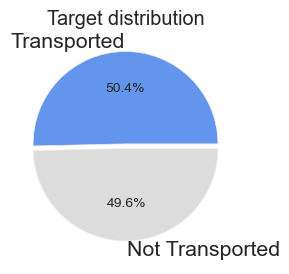

In [7]:
#Figure Size
plt.figure(figsize =(3,3))
plt.style.use('ggplot')
#pie plot
print(train.Transported.value_counts())
plt.pie(train.Transported.value_counts(),labels = ['Transported','Not Transported'], colors = ['cornflowerblue','gainsboro'],autopct='%1.1f%%',explode=(0.05,0))
plt.title('Target distribution')
plt.show()

The targe is well balanced

### Continous features

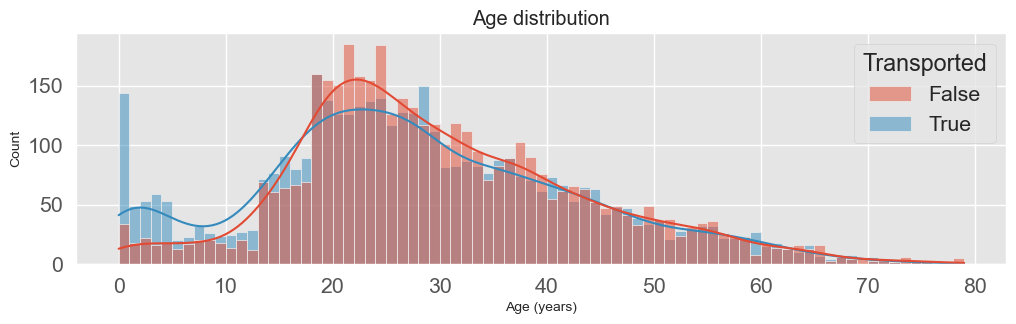

In [8]:
#figsize
plt.figure(figsize =(12,3))

#histogram
sns.histplot(data=train, x='Age', hue = 'Transported', binwidth = 1, kde =  True)
plt.title('Age distribution')
plt.xlabel('Age (years)')
plt.show()

**Notes**
* 0-18: was more likely to be transported than not. 
* 18-25 was less likely to be transported than not.
* 25-80 was equally transported or not.

A new feature to create to indicate that the passenger is a child, adolescent or adult.

### Expenditure features

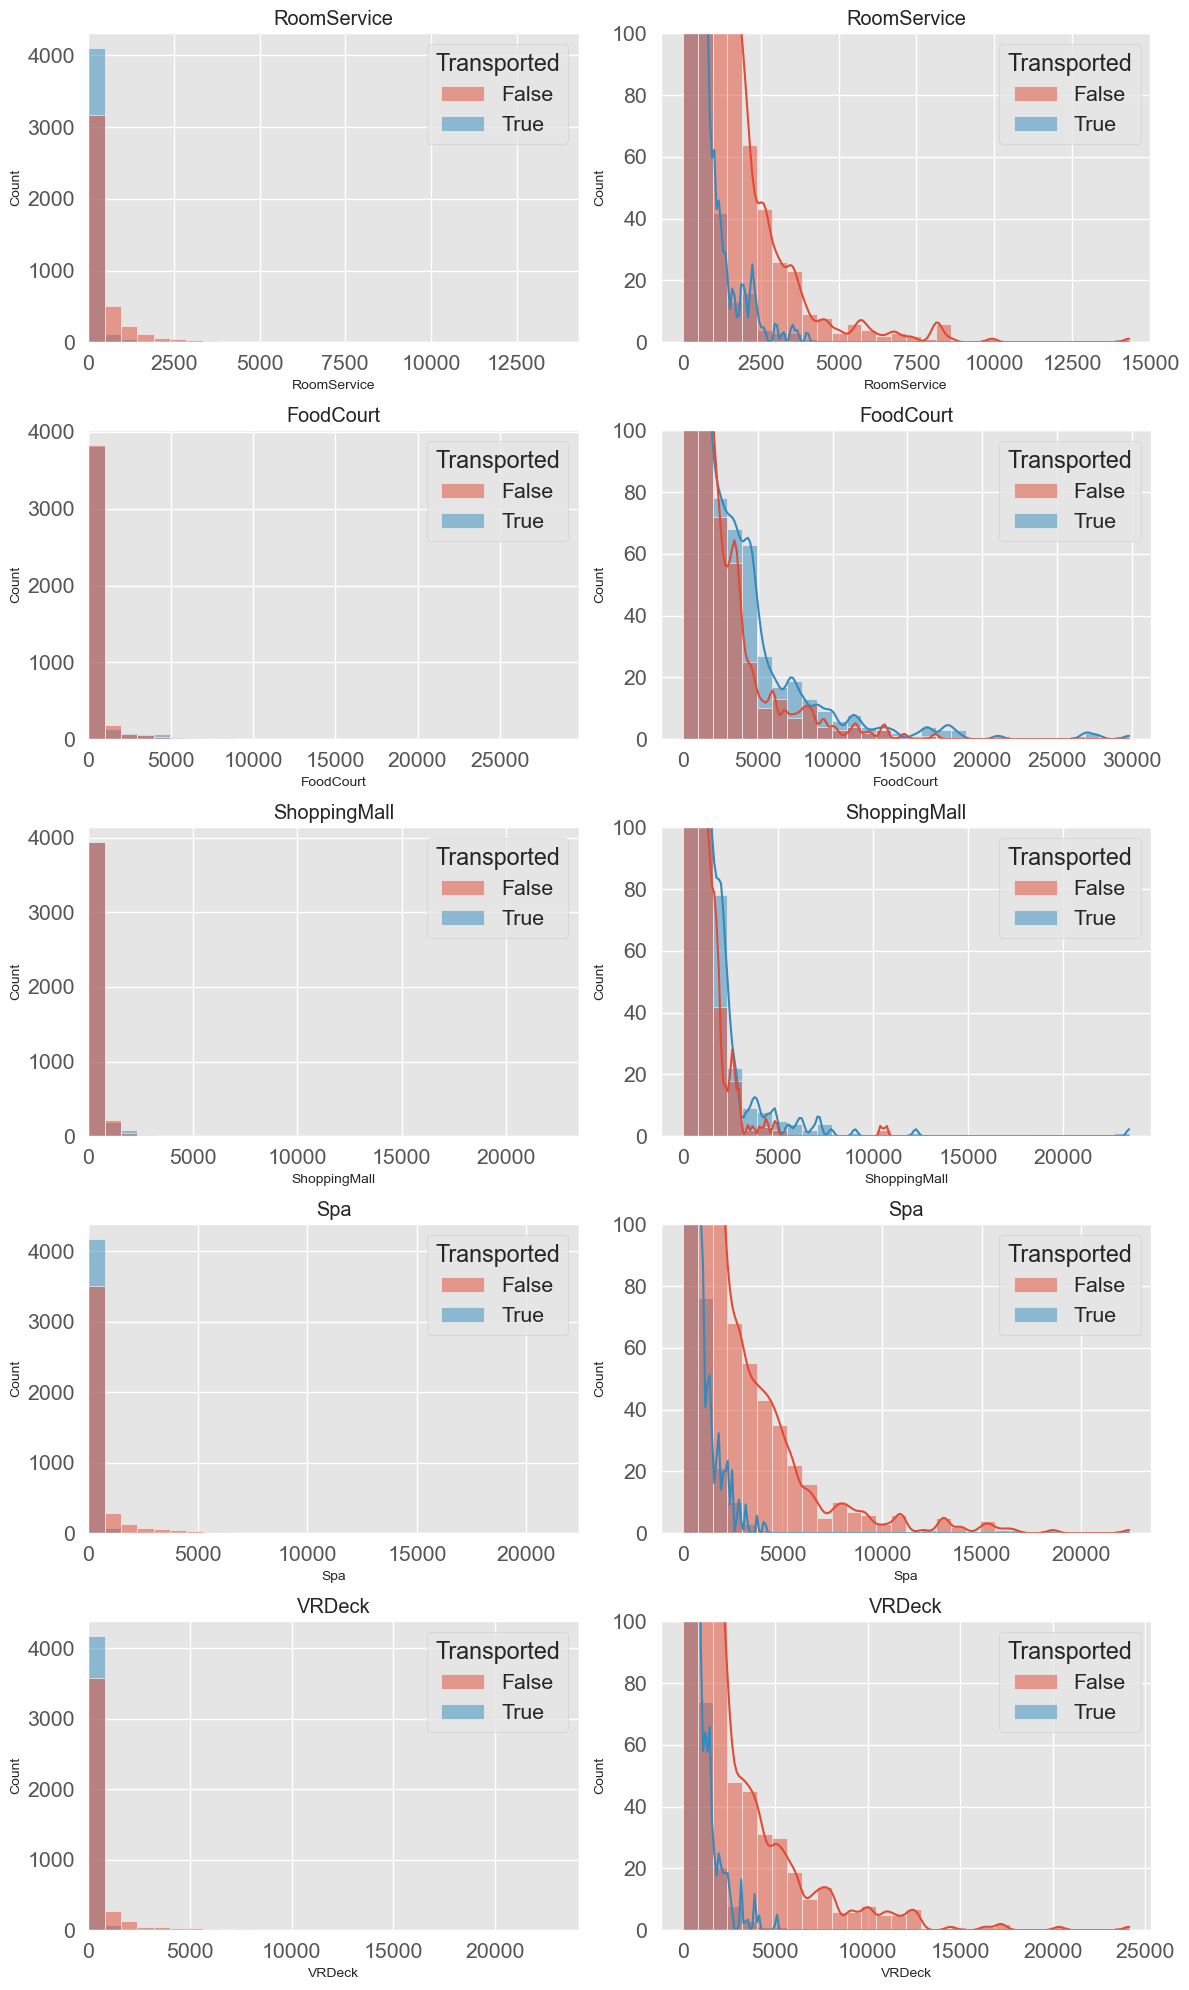

RoomService     14327.0
FoodCourt       29813.0
ShoppingMall    23492.0
Spa             22408.0
VRDeck          24133.0
dtype: float64

In [9]:
expenditure = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

#Plot
fig = plt.figure(figsize=(12,20))
for i,var in enumerate(expenditure):
    #Left_plot
    ax =fig.add_subplot(5,2,2*i+1)
    sns.histplot(data=train, x= var, hue='Transported', axes = ax, bins=30, kde=False)
    ax.set_xlim(0,train[var].max())
    
    ax.set_title(var)

    #Right_plot
    ax =fig.add_subplot(5,2,2*i+2)
    sns.histplot(data=train, x= var, hue='Transported', axes = ax, bins=30, kde=True)
    plt.ylim([0,100])
    ax.set_title(var)
plt.xlim
fig.tight_layout()
plt.show()
train[expenditure].max()    

**Notes**
* Most people don't spend any money as can see on the left plots.
* The distribution of spending decays exponentially as can see on the right plots.
* There are a small number of outliers as can see seeing the xlimits.
* People who were transported tended to spend less.
* RoomService, Spa and VrDeck have different distributions to FoodCourt and ShoppingMall. This allow to think as Luxury vs Essential amenities.

**Insight**
* Create a new feature that sum all the features to compare the total expenditure.
* Create a binary feature to indicate if a person has not spent anything.i.e. total expenditure is 0)
* Take a log transform to reduce skew.



### Categorical features

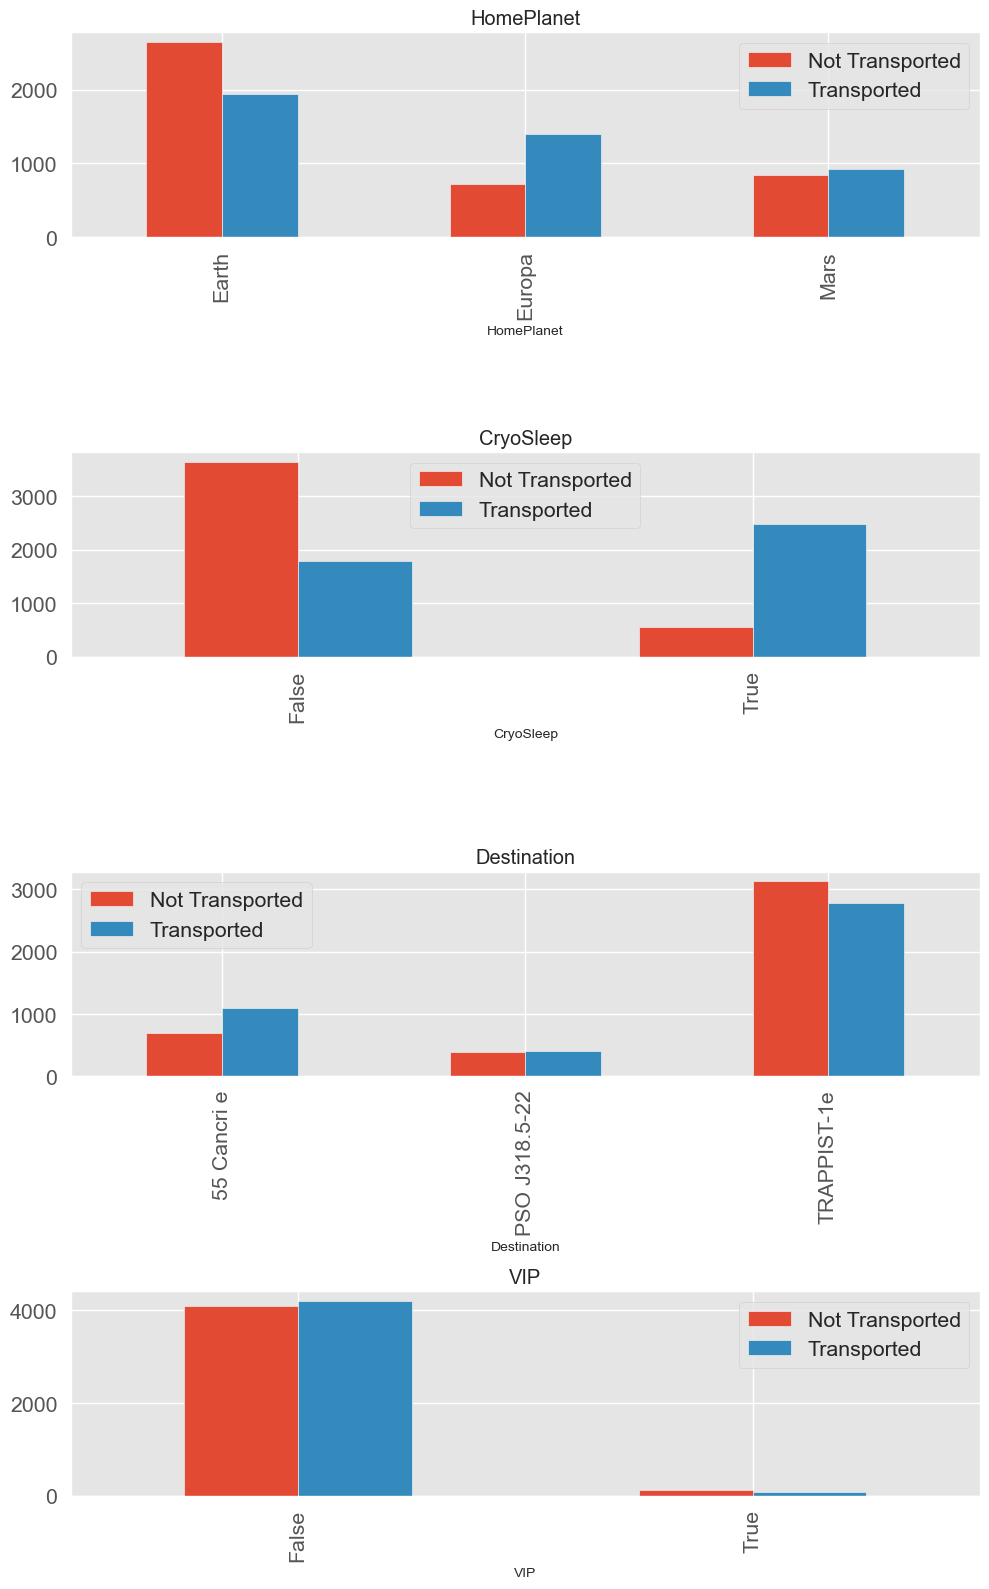

In [10]:
# Categorical features
cat_features = ['HomePlanet','CryoSleep', 'Destination', 'VIP']

#Plot
fig ,axs = plt.subplots(len(cat_features), 1,figsize=(10,16))
for i,var in enumerate(cat_features):
    ax = axs[i]
    data_grouped = train.groupby([var,'Transported']).size().unstack()
    data_grouped.plot(kind='bar',stacked=False,ax=ax)
    ax.set_title(var)
    ax.legend(['Not Transported', 'Transported'])

fig.tight_layout()
plt.show()  

**Notes**
* VIP won't be useful, the target split is more less equal.
* Cryosleep appears to be very useful feature.

**Insight**
VIP feature can be dropped to prevent overfitting

### Qualitative features

In [11]:
# Qualitative features
qual_features = ['PassengerId', 'Cabin', 'Name']

#Preview qualitative features
train[qual_features].head()

PassengerId  Cabin               Name
0     0001_01  B/0/P    Maham Ofracculy
1     0002_01  F/0/S       Juanna Vines
2     0003_01  A/0/S      Altark Susent
3     0003_02  A/0/S       Solam Susent
4     0004_01  F/1/S  Willy Santantines

**Notes**
* PassengerId takes the form aaaa_bb where aaaa is a group of passenger who is travelling with and pp is their number within the group.
* Cabin ajes the form deck/num/side, where side can be either P for Port or S for Starboard.

**Insights**
* The group and group size can be extract from the PassengerId feature.m
* The deck, number and side can be extract from the cabin feature.
* The surname can be extract from the name feature to identify families.


## Feature Engineering

The philosophy to feature engineering is **Better features make better models**

### Age status

Bin age features into groups. This will be helpful for filling missing values like expenditure according to age.

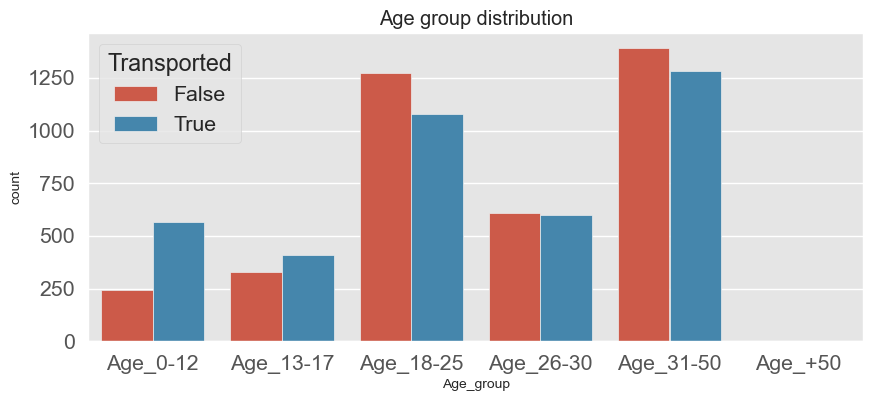

In [12]:
#New features training set
train['Age_group'] = np.nan
train.loc[train['Age']<=12,'Age_group'] = 'Age_0-12'
train.loc[(train['Age']>12) & (train['Age']<18),'Age_group'] = 'Age_13-17'
train.loc[(train['Age']>=18) & (train['Age']<=25),'Age_group'] ='Age_18-25'
train.loc[(train['Age']>25) & (train['Age']<=30),'Age_group'] ='Age_26-30'
train.loc[(train['Age']>30) & (train['Age']<=50),'Age_group'] ='Age_31-50'
train.loc[(train['Age']>50),'Age_group'] ='Age_+51'
# data_grouped = train.groupby(['Age_group','Transported']).size().unstack()
# total = data_grouped.sum(axis=1)
# percentages = (data_grouped.T / total * 100).T
# result = pd.concat([data_grouped, percentages], axis=1, keys=['Count', 'Percentage'])
# result

# New features test set
test['Age_group'] = np.nan
test.loc[test['Age']<=12,'Age_group'] = 'Age_0-12'
test.loc[(test['Age']>12) & (test['Age']<18),'Age_group'] = 'Age_13-17'
test.loc[(test['Age']>=18) & (test['Age']<=25),'Age_group'] ='Age_18-25'
test.loc[(test['Age']>25) & (test['Age']<=30),'Age_group'] ='Age_26-30'
test.loc[(test['Age']>30) & (test['Age']<=50),'Age_group'] ='Age_31-50'
test.loc[(test['Age']>50),'Age_group'] ='Age_+51'

#Plot distribution
plt.figure(figsize=(10,4))
result = sns.countplot(data = train, x='Age_group', hue='Transported', order = ['Age_0-12', 'Age_13-17', 'Age_18-25', 'Age_26-30', 'Age_31-50','Age_+50'])
plt.title('Age group distribution')
plt.show()

### Expenditure

Total expenditure and identify passengers with no expenditure.

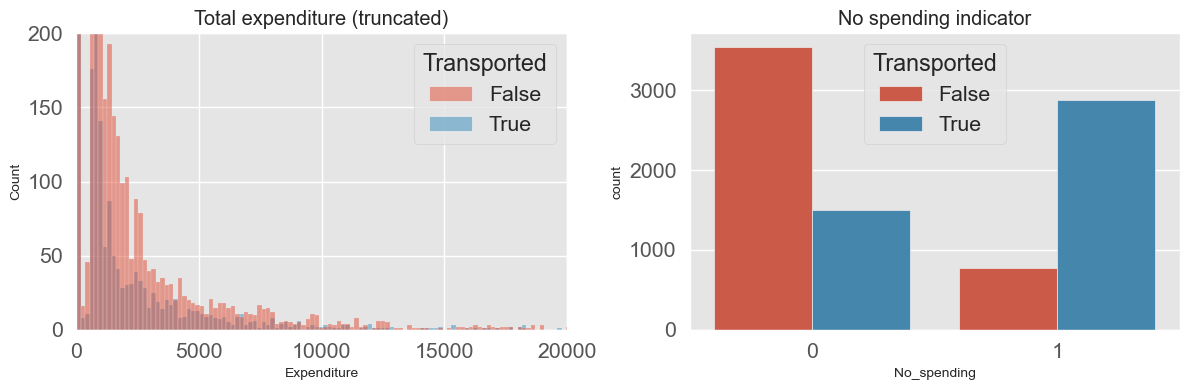

In [13]:
# New features - training set
train['Expenditure'] = train[expenditure].sum(axis=1)
train['No_spending'] = (train['Expenditure'] ==0).astype(int)

# New features - test set
test['Expenditure'] = test[expenditure].sum(axis=1)
test['No_spending'] = (test['Expenditure'] ==0).astype(int)

#Plot distriution of new features
fig = plt.figure(figsize= (12,4))
plt.subplot(1,2,1)
sns.histplot(data=train, x='Expenditure', hue='Transported', bins=200)
plt.title('Total expenditure (truncated)')
plt.xlim([0,20000])
plt.ylim([0,200])

plt.subplot(1,2,2)
sns.countplot(data=train,x='No_spending', hue='Transported')
plt.title('No spending indicator')
fig.tight_layout()

### Passenger group

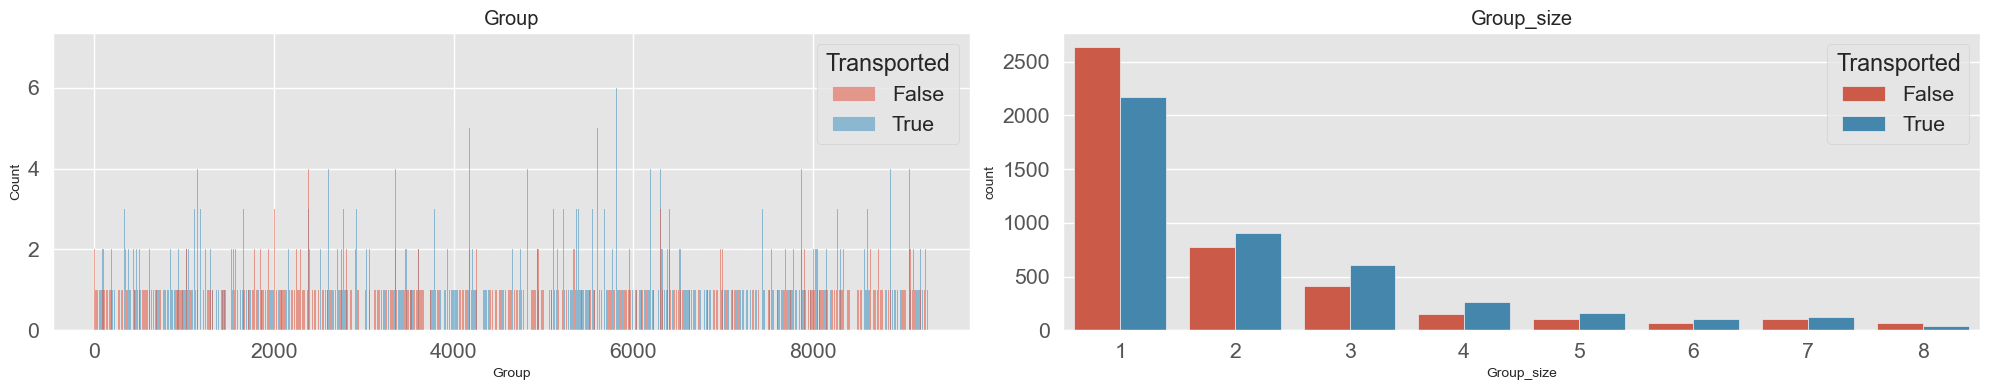

In [14]:
# New feature Group
train['Group'] = train['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)
test['Group'] = test['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)

#New feaure Group size
train['Group_size'] = train['Group'].map(lambda x: pd.concat([train['Group'], test['Group']]).value_counts()[x])
test['Group_size'] = test['Group'].map(lambda x: pd.concat([train['Group'], test['Group']]).value_counts()[x])

#Plot distribution of new features
plt.figure(figsize=(20,4))
plt.subplot(1,2,1)
sns.histplot(data=train, x = 'Group', hue='Transported', binwidth=1)
plt.title('Group')

plt.subplot(1,2,2)
sns.countplot(data=train, x = 'Group_size', hue='Transported')
plt.title('Group_size')
plt.tight_layout()

The Group feature has too big of cardinality, and would be explode the number of dimensions with one-hot encoding so we can not really use this feature.

The group size could be a useful feature, In fact, we can compress the feature by creating a 'Solo' column that tracks whether someone is travelling alone. The figure on the right shows that group size=1 is less likely transported than group size more than 1.

(0.0, 3000.0)

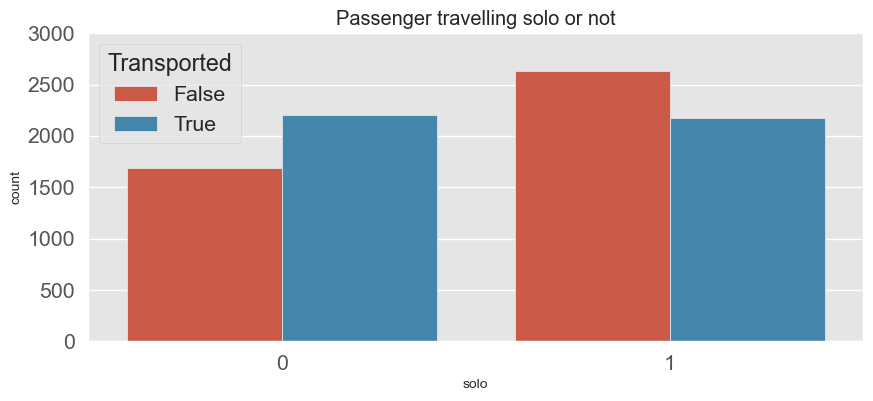

In [15]:
#New feature
train['solo'] = (train['Group_size']==1).astype(int)
test['solo'] = (test['Group_size']==1).astype(int)

plt.figure(figsize=(10,4))
sns.countplot(data=train, x = 'solo', hue='Transported')
plt.title('Passenger travelling solo or not')
plt.ylim([0,3000])

### Cabin location

In [16]:
# Replace NaNs with outliers for now (so we can split)
train['Cabin'].fillna('Z/9999/Z',inplace=True)
test['Cabin'].fillna('Z/9999/Z',inplace=True)

#New features -training set
train['Cabin_deck'] = train['Cabin'].apply(lambda x: x.split('/')[0])
train['Cabin_number'] = train['Cabin'].apply(lambda x: x.split('/')[1]).astype(int)
train['Cabin_side'] = train['Cabin'].apply(lambda x: x.split('/')[2])

#New features -test set
test['Cabin_deck'] = test['Cabin'].apply(lambda x: x.split('/')[0])
test['Cabin_number'] = test['Cabin'].apply(lambda x: x.split('/')[1]).astype(int)
test['Cabin_side'] = test['Cabin'].apply(lambda x: x.split('/')[2])

# Put Nan's back in
train.loc[train['Cabin_deck'] == 'Z','Cabin_deck'] = np.nan
train.loc[train['Cabin_number']==9999,'Cabin_number']=np.nan
train.loc[train['Cabin_side']=='Z','Cabin_side']=np.nan
test.loc[test['Cabin_deck']=='Z','Cabin_deck']=np.nan
test.loc[test['Cabin_number']==9999,'Cabin_number']=np.nan
test.loc[test['Cabin_side']=='Z','Cabin_side']=np.nan

#Drop Cabin
train.drop('Cabin',axis=1, inplace=True)
test.drop('Cabin',axis=1, inplace=True)


In [17]:
train['Cabin_number'].isna().any()

True

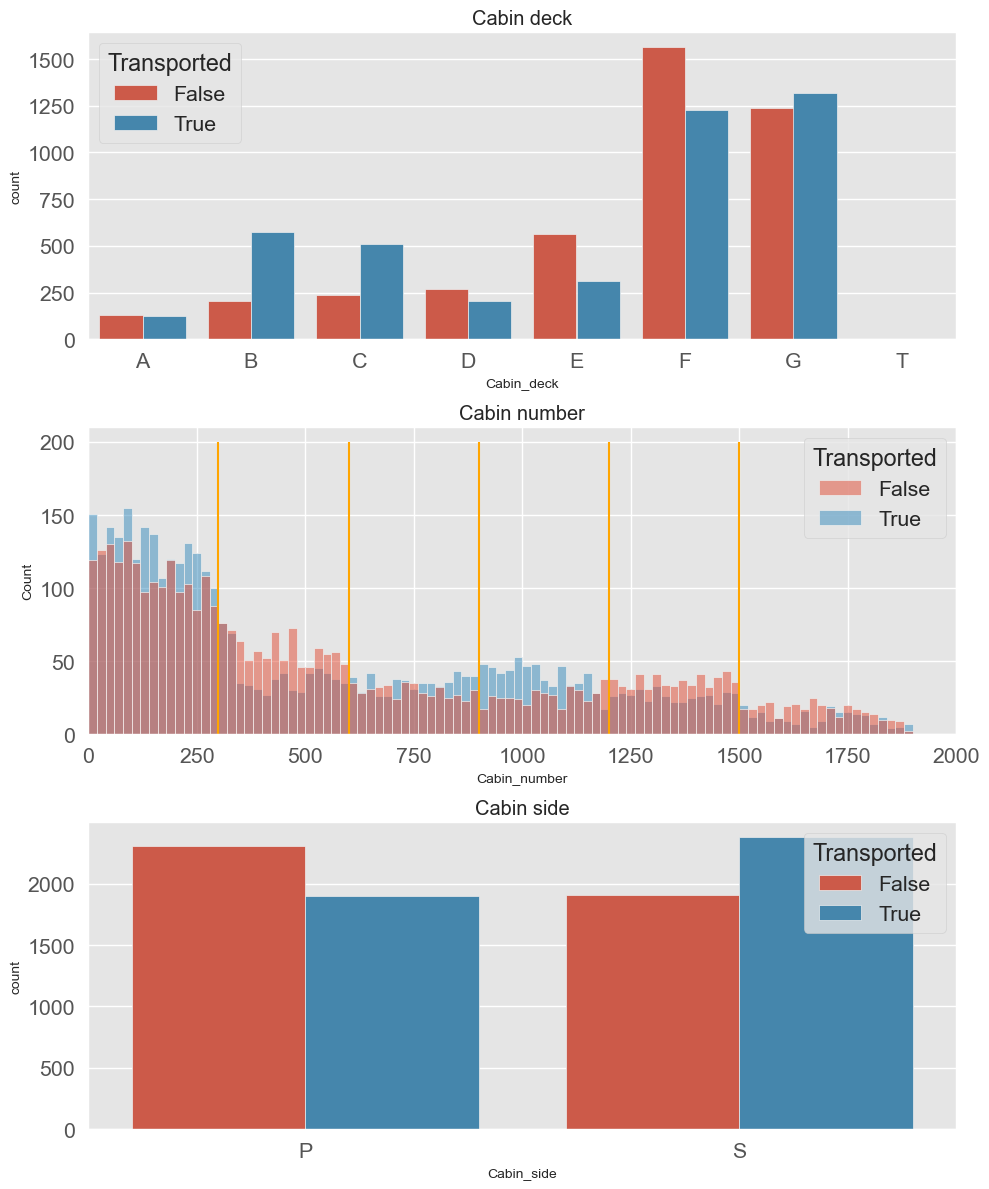

In [18]:
#Plot distribution of new features
fig=plt.figure(figsize=(10,12))
plt.subplot(3,1,1)
sns.countplot(data=train, x='Cabin_deck', hue='Transported',order = [ 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'T'])
plt.title('Cabin deck')

plt.subplot(3,1,2)
sns.histplot(data=train,x='Cabin_number', hue='Transported', binwidth = 20)
i=300
while i<1800:
    plt.vlines(i, ymin=0, ymax=200, color= 'orange')
    i+=300
plt.title('Cabin number')
plt.xlim([0,2000])

plt.subplot(3,1,3)
sns.countplot(data=train, x='Cabin_side', hue='Transported')
plt.title('Cabin side')
fig.tight_layout()

* Cabin_number is grouped into chunks of 300 cabins. So, we can compress this feature.
* The cabin deck 'T' seems to be an outlier(there are only 5 samples)

In [19]:
#New features Training set
train['Cabin_zone1'] = (train['Cabin_number']<300).astype(int)
i=300
s=2
while i<1800:
    train[f'Cabin_zone{s}'] = ((train['Cabin_number']>=i) & (train['Cabin_number']<i+300)).astype(int)
    i+=300
    s+=1
train[f'Cabin_zone{s}'] = (train['Cabin_number']>=i).astype(int)


In [20]:
#New features testing set
test['Cabin_zone1'] = (test['Cabin_number']<300).astype(int)
i=300
s=2
while i<1800:
    test[f'Cabin_zone{s}'] = ((test['Cabin_number']>=i) & (test['Cabin_number']<i+300)).astype(int)
    i+=300
    s+=1
test[f'Cabin_zone{s}'] = (test['Cabin_number']>=i).astype(int)

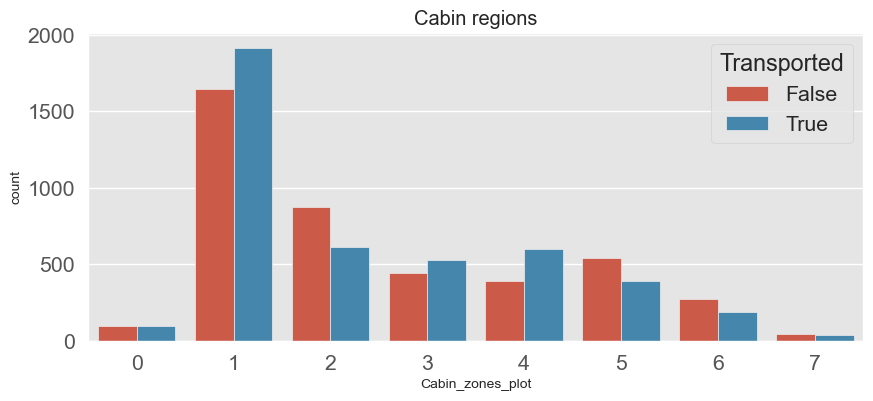

In [21]:
#Plot distribution
plt.figure(figsize=(10,4))
train['Cabin_zones_plot'] = sum(train[f'Cabin_zone{i}']*i for i in range(1,8)).astype(int)
sns.countplot(data=train, x='Cabin_zones_plot', hue='Transported')
plt.title('Cabin regions')
train.drop('Cabin_zones_plot', axis = 1, inplace= True)

### Family size

Text(0.5, 1.0, 'Family size')

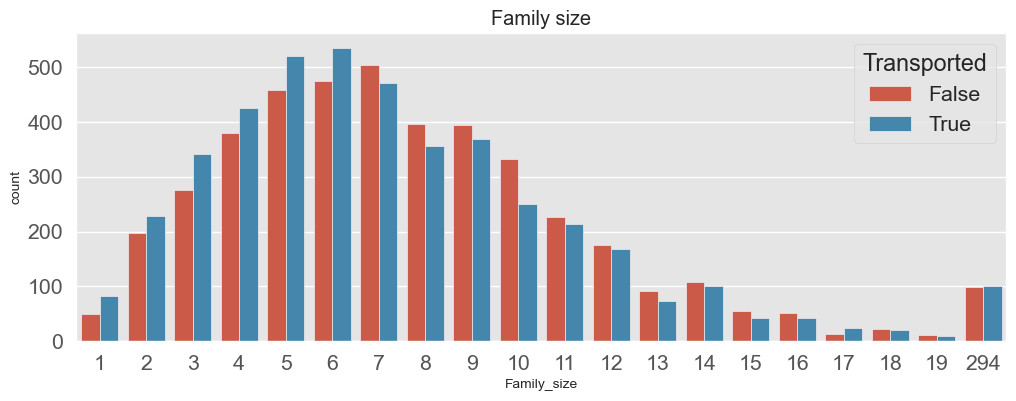

In [22]:
# Replace NAN's with outliers for now ( so we can split feature)
train['Name'].fillna('Unknown Unknown', inplace=True)
test['Name'].fillna('Unknown Unknown', inplace=True)

#New feature
train['Surname'] = train['Name'].str.split().str[-1]
test['Surname'] = test['Name'].str.split().str[-1]

#Family size
train['Family_size'] = train['Surname'].map(lambda x: pd.concat([train['Surname'], test['Surname']]).value_counts()[x])
test['Family_size'] = test['Surname'].map(lambda x: pd.concat([train['Surname'], test['Surname']]).value_counts()[x])

#Put NAN's back in
train.loc[train['Surname']=='Unknown', 'Surname'] = np.nan
train.loc[train['Family_size']>100, 'Surname'] = np.nan
test.loc[test['Surname']=='Unknown', 'Surname'] = np.nan
test.loc[test['Family_size']>100, 'Surname'] = np.nan

#Drop name
train.drop('Name',axis=1,inplace=True)
test.drop('Name',axis=1, inplace=True)

#New feature distribution
plt.figure(figsize=(12,4))
sns.countplot(data=train, x='Family_size', hue='Transported')
plt.title('Family size')

## Missing values

### Combine train and test 

This will make easier to fill missing values. We will split it later.

In [23]:
#Labels and features
y = train['Transported'].copy().astype(int)
X = train.drop('Transported', axis=1).copy()

data = pd.concat([X,test], axis=0).reset_index(drop=True)

In [24]:
data.isna().any()

PassengerId     False
HomePlanet       True
CryoSleep        True
Destination      True
Age              True
VIP              True
RoomService      True
FoodCourt        True
ShoppingMall     True
Spa              True
VRDeck           True
Age_group        True
Expenditure     False
No_spending     False
Group           False
Group_size      False
solo            False
Cabin_deck       True
Cabin_number     True
Cabin_side       True
Cabin_zone1     False
Cabin_zone2     False
Cabin_zone3     False
Cabin_zone4     False
Cabin_zone5     False
Cabin_zone6     False
Cabin_zone7     False
Surname          True
Family_size     False
dtype: bool

### Explore missing values

In [25]:
#Columns with missing values
na_cols = data.columns[data.isna().any()].tolist()

# Missing values summary
mv = pd.DataFrame(data[na_cols].isna().sum(), columns=['Number_missing'])
mv['Percentage_missing'] =np.round(100*mv['Number_missing']/len(data),2)
mv

Number_missing  Percentage_missing
HomePlanet               288                2.22
CryoSleep                310                2.39
Destination              274                2.11
Age                      270                2.08
VIP                      296                2.28
RoomService              263                2.03
FoodCourt                289                2.23
ShoppingMall             306                2.36
Spa                      284                2.19
VRDeck                   268                2.07
Age_group                270                2.08
Cabin_deck               299                2.31
Cabin_number             299                2.31
Cabin_side               299                2.31
Surname                  294                2.27

Text(0.5, 1.0, 'Heatmap of missing values')

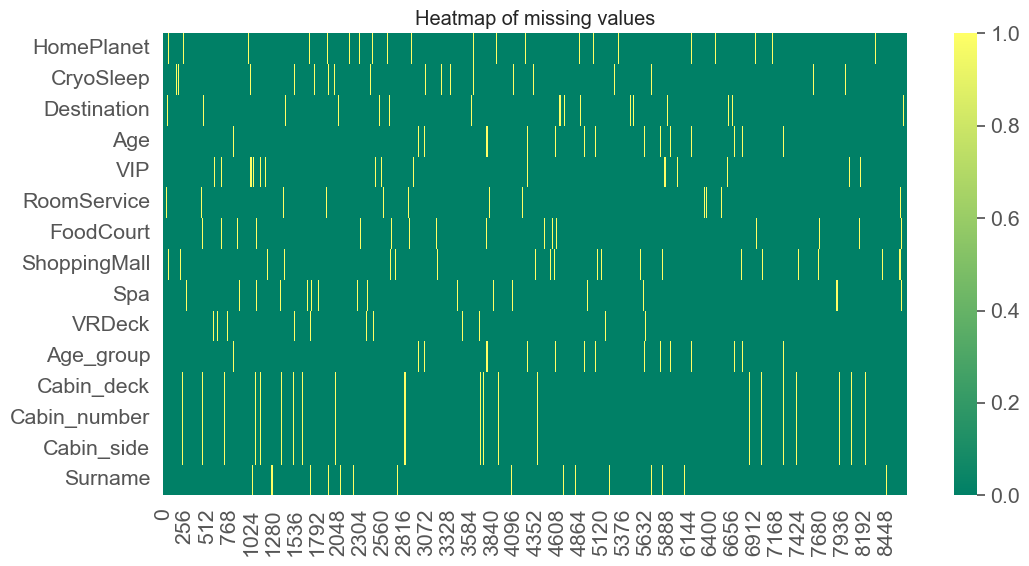

In [26]:
#Heatmap of missing values
plt.figure(figsize=(12,6))
sns.heatmap(train[na_cols].isna().T,cmap='summer')
plt.title('Heatmap of missing values')

Missing values is around 2%. It seems that there is a variety of missing values over the entire dataframe.

Text(0.5, 1.0, 'Number of missing values by passenger')

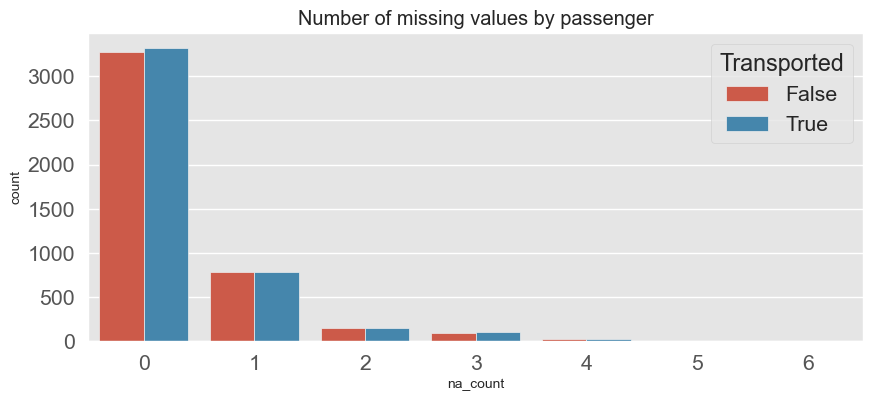

In [27]:
#Countplot of number of missing values by passenger
train['na_count']=train.isna().sum(axis=1)
plt.figure(figsize=(10,4))
sns.countplot(data=train, x='na_count', hue='Transported')
plt.title('Number of missing values by passenger')


In [28]:
count_na = train['na_count'].value_counts()
print('percentage of rows with 0s missing values: ', 100*count_na[0]/len(train))
print('percentage of rows with some missing values: ', 100 - 100*count_na[0]/len(train))
train.drop('na_count', axis=1, inplace=True)

percentage of rows with 0s missing values:  75.99217761417232
percentage of rows with some missing values:  24.00782238582768


*Notes*

* Missing values are independent of the target and for most part are isolated.
* Even though only 2% of the data is missing, about 25% of all passengers have at least 1 missng value.
* PassengerId is only feature to not have any missing values.

*Insight*
* Since most of te missing values are isolated it makes sense to try to fill thes in as opposed to just dropping rows.
* If there is a relationship between PassngerId and other features we can fill missing values according to this column.

### Strategy

The easiest way to deal with missing values is to just use the median for continuous features and the mode for categorical features. 
This will work 'well enough' but if we want to maximise the accuracy of our models then we need to look for patterns within the missing data. The way to do this is by looking at the joint distribution of features: 
do passengers from the same group tend to come from the same family? T
here are obviously many combinations so we will just summarise the useful trends I and others have found.

**HomePlanet and Group**

In [29]:
#Joint distribution of Group and HomePlanet
GHP_gb=data.groupby(['Group','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)
GHP_gb.tail()

HomePlanet  Earth  Europa  Mars
Group                          
9276          0.0     1.0   0.0
9277          1.0     0.0   0.0
9278          1.0     0.0   0.0
9279          1.0     0.0   0.0
9280          0.0     2.0   0.0

In [30]:
GHP_gb.tail()

HomePlanet  Earth  Europa  Mars
Group                          
9276          0.0     1.0   0.0
9277          1.0     0.0   0.0
9278          1.0     0.0   0.0
9279          1.0     0.0   0.0
9280          0.0     2.0   0.0

In [31]:
#Countplot of unique values
(GHP_gb > 0).sum(axis=1).count()

9124

This shows that everyone in the same group comesw from the same home planet. So we can fill the missing HomePlanet values according to the group.

In [32]:
# Missing values before 
HP_bef=data['HomePlanet'].isna().sum()
print('#HomePlanet missing values before:',HP_bef)
#Passengers with missing HomePlanet and in a group with known HomePlanet
Aux1 = data[data['HomePlanet'].isna()]
Aux2 = Aux1['Group']
Aux3 = (Aux2).isin(GHP_gb.index)
GHP_index = Aux1[Aux3].index

#Fill corresponding missing values
data.loc[GHP_index,'HomePlanet']=data.iloc[GHP_index,:]['Group'].map(lambda x: GHP_gb.idxmax(axis=1)[x])
#data.iloc[GHP_index,:]['Group']

# Print number of missing values left
print('#HomePlanet missing values after:',data['HomePlanet'].isna().sum())

#HomePlanet missing values before: 288
#HomePlanet missing values after: 157


**HomePlanet and CabinDeck**

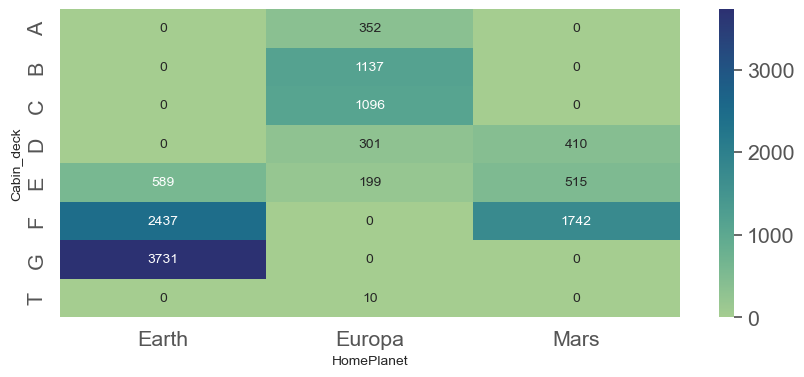

In [33]:
#Joint distribution of CabinDeck and HomePlanet
CDHP_gb = data.groupby(['Cabin_deck','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)
CDHP_gb

#Heatmap
plt.figure(figsize=(10,4))
sns.heatmap(CDHP_gb,annot=True, fmt='g', cmap='crest')
plt.show()

*Notes:*
* Passengers on Cabin decks G came from Earth.
* Passengers on Cabin decks A,B,C or T came from Europa.
* Passengers on Cabin decks D,E, F, came from multiple planets.

In [34]:
#Missing values
HP_bef = data['HomePlanet'].isna().sum()

#Decks A, B, C or T came from Europa
data.loc[(data['HomePlanet'].isna()) & (data['Cabin_deck'].isin(['A','B','C','T'])),'HomePlanet'] = 'Europa'

#Decks G  came from Earth
data.loc[(data['HomePlanet'].isna()) & (data['Cabin_deck'].isin(['G'])),'HomePlanet'] = 'Earth'

# Print number of missing values left
print('#HomePlanet missing values after:',data['HomePlanet'].isna().sum())

#HomePlanet missing values after: 94


**HomePlanet and Surname**

In [35]:
#Joint distribution of Surname and HomePlanet
SHP_gb = data.groupby(['Surname','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)
(SHP_gb>0).sum(axis=1).count()
SHP_gb

HomePlanet   Earth  Europa  Mars
Surname                         
Acobson        5.0     0.0   0.0
Acobsond       8.0     0.0   0.0
Adavisons     10.0     0.0   0.0
Adkinson       4.0     0.0   0.0
Admingried     0.0     4.0   0.0
...            ...     ...   ...
Wynneyerson    2.0     0.0   0.0
Yanton         8.0     0.0   0.0
Yatters        8.0     0.0   0.0
Yorkland      13.0     0.0   0.0
Youngrayes     7.0     0.0   0.0

[2402 rows x 3 columns]

Everyone wih the same surname comes from the same homeplanet

In [36]:
# Missing values before
HP_bef=data['HomePlanet'].isna().sum()

# Passengers with missing HomePlanet and in a family with known HomePlanet
SHP_index=data[data['HomePlanet'].isna()][(data[data['HomePlanet'].isna()]['Surname']).isin(SHP_gb.index)].index

# Fill corresponding missing values
data.loc[SHP_index,'HomePlanet']=data.iloc[SHP_index,:]['Surname'].map(lambda x: SHP_gb.idxmax(axis=1)[x])

# Print number of missing values left
print('#HomePlanet missing values before:',HP_bef)
print('#HomePlanet missing values after:',data['HomePlanet'].isna().sum())
#SHP_index

#HomePlanet missing values before: 94
#HomePlanet missing values after: 10


In [37]:
#Only 10 HomePlanet missing values left 
data[data['HomePlanet'].isna()].iloc[:, :18]

PassengerId HomePlanet CryoSleep  Destination   Age    VIP  RoomService  \
2274      2443_01        NaN     False  TRAPPIST-1e  31.0  False       1458.0   
2631      2817_01        NaN     False  TRAPPIST-1e  25.0  False        237.0   
3091      3331_01        NaN     False  TRAPPIST-1e  40.0  False        666.0   
4548      4840_01        NaN      True  TRAPPIST-1e  36.0  False          0.0   
5762      6108_01        NaN     False  TRAPPIST-1e  13.0  False        206.0   
8969      0616_01        NaN     False  TRAPPIST-1e  31.0  False          0.0   
10583     4052_01        NaN     False  TRAPPIST-1e  26.0  False          6.0   
11913     7065_01        NaN      True  TRAPPIST-1e  28.0  False          0.0   
12551     8435_01        NaN       NaN  TRAPPIST-1e  19.0  False        162.0   
12725     8775_01        NaN      True  TRAPPIST-1e  40.0  False          0.0   

       FoodCourt  ShoppingMall     Spa  VRDeck  Age_group  Expenditure  \
2274       421.0          76.0     0.0     0.0  Age_31-50       1955.0   
2631         0.0         910.0     0.0    12.0  Age_18-25       1159.0   
3091         4.0          83.0     0.0    50.0  Age_31-50        803.0   
4548         0.0           NaN     0.0     0.0  Age_31-50          0.0   
5762        28.0           0.0     1.0   629.0  Age_13-17        864.0   
8969       428.0           NaN  1154.0  1025.0  Age_31-50       2607.0   
10583     5903.0           0.0   240.0    72.0  Age_26-30       6221.0   
11913        0.0           0.0     0.0     NaN  Age_26-30          0.0   
12551       11.0           0.0     0.0  1216.0  Age_18-25       1389.0   
12725        0.0           0.0     0.0     0.0  Age_31-50          0.0   

       No_spending  Group  Group_size  solo Cabin_deck  
2274             0   2443           1     1          D  
2631             0   2817           1     1          F  
3091             0   3331           1     1          F  
4548             1   4840           1     1          F  
5762             0   6108           1     1          F  
8969             0    616           1     1          E  
10583            0   4052           1     1          D  
11913            1   7065           1     1          E  
12551            0   8435           1     1          F  
12725            1   8775           1     1          D

Everyone left the planet towards TRAPPIST-1e.

**HomePlanet and Destination**

<Axes: xlabel='Destination', ylabel='HomePlanet'>

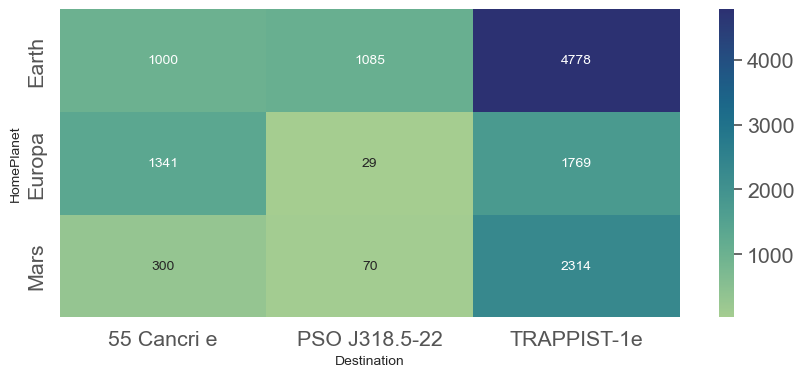

In [38]:
#Joint distribution of HomePlanet and Destination
DHP_gb=data.groupby(['HomePlanet','Destination'])['Destination'].size().unstack().fillna(0)

#Heatmap of missing values
plt.figure(figsize=(10,4))
sns.heatmap(DHP_gb, annot=True, fmt='g', cmap='crest')

Most people heading towards TRAPPIST-1e came from Earth so it makes sense to guess they come from there. But remember from earlier, no one on deck D came from Earth so we need to filter these out.

In [39]:
#Missing values before
HP_bef=data['HomePlanet'].isna().sum()

#Fill remaining HomePlanet missing values with Earth (if not on deck D) or Mars (if on Deck D)
data.loc[(data['HomePlanet'].isna()) & ~(data['Cabin_deck']=='D'),'HomePlanet'] = 'Earth'
data.loc[(data['HomePlanet'].isna()) & (data['Cabin_deck']=='D'),'HomePlanet'] = 'Mars'

# Print number of missing values left
print('#HomePlanet missing values before:',HP_bef)
print('#HomePlanet missing values after:',data['HomePlanet'].isna().sum())

#HomePlanet missing values before: 10
#HomePlanet missing values after: 0


**Destination**

Since he majority(68%) of passengers are heading towards TRAPPIST-1e. We'll just impute this value(i.e. the mode). A better rule hasn't been found at this stage.

In [40]:
#Missing values before
D_bef = data['Destination'].isna().sum()
D_bef

#Fill missin Desination values wih mode
data.loc[(data['Destination'].isna()),'Destination'] = 'TRAPPIST-1e'

# Print number of missing values left
print('#Destination missing values before:',D_bef)
print('#Destination missing values after:',data['Destination'].isna().sum())

#Destination missing values before: 274
#Destination missing values after: 0


**Surname and Group**

The reason we are fillin missing surnames is because we will use surnames later to fill missing values of other features. It also means we can improve the accuracy of the family size feature.

In [41]:
# Joint distribution of Group and Surname
GSN_gb=data[data['Group_size']>1].groupby(['Group','Surname'])['Surname'].size().unstack().fillna(0)

d = pd.DataFrame((GSN_gb>0).sum(axis=1))
d = d.groupby(0).size()
d= pd.DataFrame(d)
d.rename(columns={0: 'Count'}, inplace=True)

# Countplot of unique values
# plt.figure(figsize=(10,4))
# sns.countplot(x=(GSN_gb>0).sum(axis=1))
# plt.title('Number of unique surnames by group')
# plt.xlabel('Group')
# plt.ylabel('Count')
print('Number of unique surnames by group')
d

Number of unique surnames by group


Count
0       
1   1769
2    322
3     43
4      1

In [42]:
# Missing values before
SN_bef=data['Surname'].isna().sum()

# Passengers with missing Surname and in a group with known majority Surname
GSN_index=data[data['Surname'].isna()][(data[data['Surname'].isna()]['Group']).isin(GSN_gb.index)].index

## Fill corresponding missing values
data.loc[GSN_index,'Surname']=data.loc[GSN_index,:]['Group'].map(lambda x: GSN_gb.idxmax(axis=1)[x])

# Print number of missing values left
print('#Surname missing values before:',SN_bef)
print('#Surname missing values after:',data['Surname'].isna().sum())
#data.loc[GSN_index,:]['Group']

#Surname missing values before: 294
#Surname missing values after: 155


This is the best we can do. We do not have to get rid of all of these missing values because we will end up dropping the surname feature anyway. However, wcan update the family size feature.

In [43]:
#Replace NaN's with outliers (so we can use map)
data['Surname'].fillna('Unknown',inplace=True)

#Update family size feature
data['Family_size']=data['Surname'].map(lambda x: data['Surname'].value_counts()[x])

#Put NaN's back in place of outliers's
data.loc[data['Surname']=='Unknown','Surname']=np.nan

#Say unknown surname means no family
data.loc[data['Family_size']>100,'Family_size']=0

**CabinSide and Group**

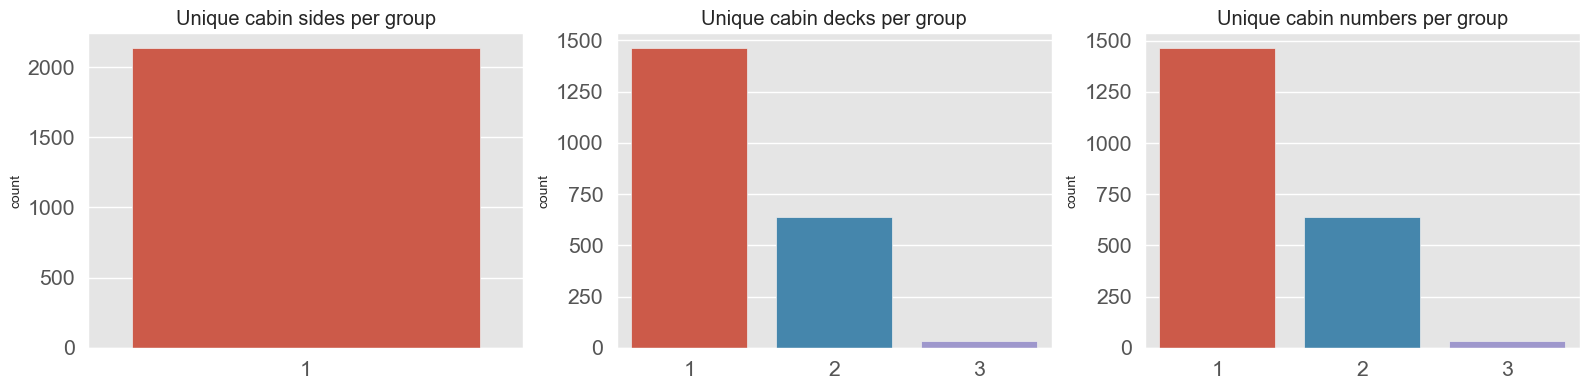

In [44]:
#Joint distribution of Group and CabinSide features
GCS_gb = data[data['Group_size']>1].groupby(['Group','Cabin_side'])['Cabin_side'].size().unstack().fillna(0)
GCD_gb = data[data['Group_size']>1].groupby(['Group','Cabin_deck'])['Cabin_deck'].size().unstack().fillna(0)
GCN_gb = data[data['Group_size']>1].groupby(['Group','Cabin_number'])['Cabin_number'].size().unstack().fillna(0)

#Countplots
fig = plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
sns.countplot(x=(GCS_gb>0).sum(axis=1))
plt.title('Unique cabin sides per group')

plt.subplot(1,3,2)
sns.countplot(x=(GCD_gb>0).sum(axis=1))
plt.title('Unique cabin decks per group')

plt.subplot(1,3,3)
sns.countplot(x=(GCN_gb>0).sum(axis=1))
plt.title('Unique cabin numbers per group')
plt.tight_layout()
#(GCD_gb>0).sum(axis=1).value_counts().values

Everyone in the same group are in the same cabin sides. For cabin deck and cabin numer there is also a fairly good(but not perfect) correlation with group. 
Al ser grupos de 2 o más integrantes si en este caso hay un missing value quiere decir que ese missing value está en el Cabin side del otro porque son del mismo grupo.

In [45]:
#Missing values
CS_bef = data['Cabin_side'].isna().sum()

#Passengers wit missing Cabin side and in a group with know Cabin side
#data[data['Cabin_side'].isna()][
GCS_index = data[data['Cabin_side'].isna()][(data[data['Cabin_side'].isna()]['Group']).isin(GCS_gb.index)].index
data.loc[GCS_index,'Cabin_side'] = data.loc[GCS_index,:]['Group'].map(lambda x: GCS_gb.idxmax(axis=1)[x])
GCS_gb.idxmax(axis=1)
# Print number of missing values left
print('#Cabin_side missing values before:',CS_bef)
print('#Cabin_side missing values after:',data['Cabin_side'].isna().sum())

#Cabin_side missing values before: 299
#Cabin_side missing values after: 162


**Cabin_side and surname**

Text(0.5, 1.0, 'Ratio of cabin side by surname')

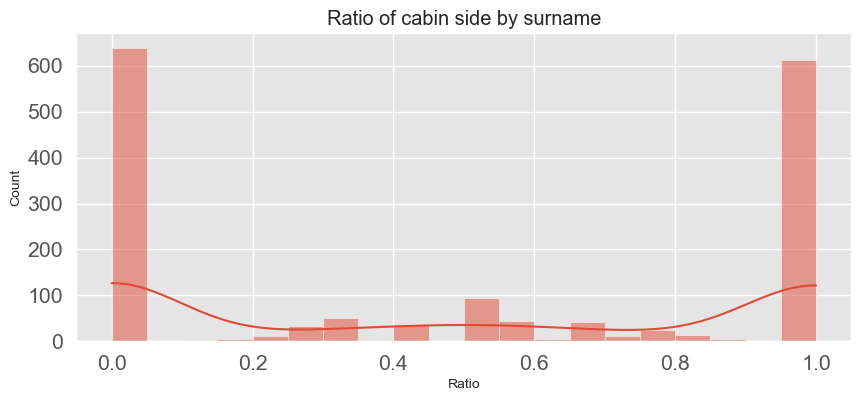

In [46]:
#Joint distribution of Cabin side and Surname
CSS_gb=data[data['Group_size']>1].groupby(['Surname','Cabin_side']).size().unstack().fillna(0)

#Ratio
CSS_gb['Ratio'] = CSS_gb['P']/(CSS_gb['P']+CSS_gb['S'])
#Countplot
plt.figure(figsize=(10,4))
sns.histplot(CSS_gb['Ratio'], kde=True, binwidth=0.05)
plt.title('Ratio of cabin side by surname')
#CSS_gb.drop('Z',axis=1,inplace=True)

Con el ratio tenemos cuantos con el mismo apellido estan en el mismo CabinSide.

In [47]:
#Print proportion
print('Percentage of families all on the same cabin side:',np.round((len(CSS_gb[CSS_gb['Ratio']==0])+len(CSS_gb[CSS_gb['Ratio']==1]))/len(CSS_gb)*100,1))
#100*np.round((SCS_gb['Ratio'].isin([0,1])).sum()/len(SCS_gb),3)

Percentage of families all on the same cabin side: 76.7


Families tend to be in the same Cabin_side

In [48]:
#Missing values
CS_bef = data['Cabin_side'].isna().sum()

#Passengers wit missing Cabin side and in with same Surnames with know Cabin side
CSS_index = data[data['Cabin_side'].isna()][(data[data['Cabin_side'].isna()]['Surname']).isin(CSS_gb.index)].index

#Fill corresponding missing values
data.loc[CSS_index,'Cabin_side'] = data.loc[CSS_index,:]['Surname'].map(lambda x: CSS_gb.idxmax(axis=1)[x])

# Drop surname (we don't need it anymore)
data.drop('Surname', axis=1, inplace=True)

# Print number of missing values left
print('#Cabin_side missing values before:',CS_bef)
print('#Cabin_side missing values after:',data['Cabin_side'].isna().sum())


#Cabin_side missing values before: 162
#Cabin_side missing values after: 66


The remaning missing values will be replaced with an outlier. This is because we really do not know wich one of the two(balanced) sides we should assign.

In [49]:
#Value counts
data['Cabin_side'].value_counts()

S    6504
P    6400
Name: Cabin_side, dtype: int64

In [50]:
#Missing values before
CS_bef = data['Cabin_side'].isna().sum()

#Fill remaining missing values with an outlier
data.loc[data['Cabin_side'].isna(),'Cabin_side']='Z'

# Print number of missing values left
print('#Cabin_side missing values before:',CS_bef)
print('#Cabin_side missing values after:',data['Cabin_side'].isna().sum())

#Cabin_side missing values before: 66
#Cabin_side missing values after: 0


**Cabin_deck and Group**

In [51]:
#Missing values
CD_bef = data['Cabin_deck'].isna().sum()

#Passengers wit missing Cabin deck and in with same Group with know Cabin side
GCD_index = data[data['Cabin_deck'].isna()][(data[data['Cabin_deck'].isna()]['Group']).isin(GCD_gb.index)].index

#Fill corresponding missing values
data.loc[GCD_index,'Cabin_deck'] = data.loc[GCD_index,:]['Group'].map(lambda x: GCD_gb.idxmax(axis=1)[x])

# Print number of missing values left
print('#Cabin_deck missing values before:',CD_bef)
print('#Cabin_deck missing values after:',data['Cabin_deck'].isna().sum())

#Cabin_deck missing values before: 299
#Cabin_deck missing values after: 162


**Cabin_deck and HomePlanet**

In [52]:
#Joint distribution of CabinDeck and HomePlanet
data.groupby(['HomePlanet','Destination','solo','Cabin_deck'])['Cabin_deck'].size().unstack().fillna(0)

Cabin_deck                         A      B      C      D      E       F  \
HomePlanet Destination   solo                                              
Earth      55 Cancri e   0       0.0    0.0    0.0    0.0   20.0    90.0   
                         1       0.0    0.0    0.0    0.0   47.0   289.0   
           PSO J318.5-22 0       0.0    0.0    0.0    0.0   18.0    67.0   
                         1       0.0    0.0    0.0    0.0   25.0   262.0   
           TRAPPIST-1e   0       0.0    0.0    0.0    0.0  133.0   438.0   
                         1       0.0    0.0    0.0    0.0  358.0  1350.0   
Europa     55 Cancri e   0      96.0  377.0  313.0   59.0   35.0     0.0   
                         1      67.0  141.0  159.0   46.0   34.0     0.0   
           PSO J318.5-22 0       2.0    5.0   11.0    0.0    0.0     0.0   
                         1       0.0    0.0   10.0    0.0    0.0     0.0   
           TRAPPIST-1e   0     152.0  459.0  428.0  120.0   53.0     0.0   
                         1      44.0  179.0  201.0   84.0   82.0     0.0   
Mars       55 Cancri e   0       0.0    0.0    0.0   32.0   15.0   104.0   
                         1       0.0    0.0    0.0   40.0   16.0    92.0   
           PSO J318.5-22 0       0.0    0.0    0.0    8.0    9.0    14.0   
                         1       0.0    0.0    0.0    9.0    7.0    21.0   
           TRAPPIST-1e   0       0.0    0.0    0.0  168.0  219.0   798.0   
                         1       0.0    0.0    0.0  164.0  263.0   743.0   

Cabin_deck                          G    T  
HomePlanet Destination   solo               
Earth      55 Cancri e   0      272.0  0.0  
                         1      269.0  0.0  
           PSO J318.5-22 0      230.0  0.0  
                         1      466.0  0.0  
           TRAPPIST-1e   0     1075.0  0.0  
                         1     1509.0  0.0  
Europa     55 Cancri e   0        0.0  2.0  
                         1        0.0  0.0  
           PSO J318.5-22 0        0.0  0.0  
                         1        0.0  0.0  
           TRAPPIST-1e   0        0.0  1.0  
                         1        0.0  8.0  
Mars       55 Cancri e   0        0.0  0.0  
                         1        0.0  0.0  
           PSO J318.5-22 0        0.0  0.0  
                         1        0.0  0.0  
           TRAPPIST-1e   0        0.0  0.0  
                         1        0.0  0.0

*Notes*
* Passengers from Mars are most likely in deck F.
* Passengers from Europa are(more or less) most likely in deck C travelling solo and deck B otherwise.
* Passengers from Earth are(more or less) most likely in deck G.

We will fill in missing vales according to where the mde appears in thes

In [53]:
#Missing values
CD_bef = data['Cabin_deck'].isna().sum()

#Fill missing Cabin decks values wih mode
# data.loc[(data['Cabin_deck'].isna()) & (data['HomePlanet']=Mars),'Cabin_deck'] = 'F'
# data.loc[(data['Cabin_deck'].isna()) & (data['HomePlanet']=Europa) & data['solo']=0,'Cabin_deck'] = 'B'
# data.loc[(data['Cabin_deck'].isna()) & (data['HomePlanet']=Europa) & data['solo']=1,'Cabin_deck'] = 'C'
# data.loc[(data['Cabin_deck'].isna()) & (data['HomePlanet']=Earth),'Cabin_deck'] = 'G'
na_rows_CD=data.loc[data['Cabin_deck'].isna(),'Cabin_deck'].index
data.loc[data['Cabin_deck'].isna(),'Cabin_deck']= data.groupby(['HomePlanet','Destination','solo'])['Cabin_deck'].transform(lambda x:x.fillna(pd.Series.mode(x)[0]))[na_rows_CD]

# Print number of missing values left
print('#Destination missing values before:',CD_bef)
print('#Destination missing values after:',data['Cabin_deck'].isna().sum())

#Destination missing values before: 162
#Destination missing values after: 0


**CabinNumber and CabinDeck**

Text(0.5, 1.0, 'Cabin_number vs group coloured by group')

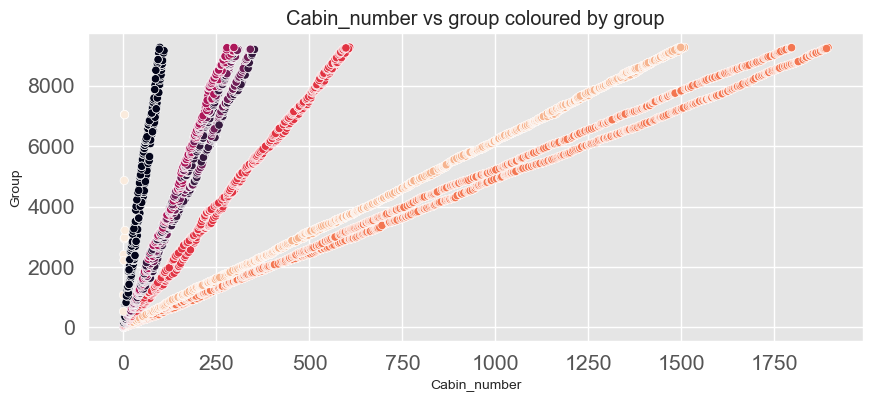

In [54]:
#scatterplot
plt.figure(figsize=(10,4))
sns.scatterplot(x=data['Cabin_number'], y=data['Group'], c=LabelEncoder().fit_transform(data.loc[~data['Cabin_number'].isna(),'Cabin_deck']))
plt.title('Cabin_number vs group coloured by group')                                                                                                 

There is an interesting pattern here. The cabin_number and group_number share a linear relationship on a deck b deck basis. We can therefore extrapolate the missing cabin numbers sing linear reression on adeck by deck basis to get an approximate cabin number.

In [55]:
# Missig values efore
CN_bef = data['Cabin_number'].isna().sum()

#Extrapolate linear relationship on a deck by deck basis
for deck in ['A', 'B', 'C', 'D', 'E', 'F', 'G']:
    #Features and labels
    X_CN = data.loc[~(data['Cabin_number'].isna()) & (data['Cabin_deck']==deck),'Group']
    y_CN = data.loc[~(data['Cabin_number'].isna()) & (data['Cabin_deck']==deck),'Cabin_number']
    X_test_CN = data.loc[(data['Cabin_number'].isna()) & (data['Cabin_deck']==deck),'Group']
    
    #Linear regression
    model_CN = LinearRegression()
    model_CN.fit(X_CN.values.reshape(-1,1),y_CN)
    preds_CN = model_CN.predict(X_test_CN.values.reshape(-1, 1))
    
    # Fill missing values with predictions 
    data.loc[(data['Cabin_number'].isna()) & (data['Cabin_deck']==deck),'Cabin_number'] = preds_CN.astype(int)

#Print number of missing values left
print('#Cabin_number missing values before:',CN_bef)
print('#Cabin_number missing values after:',data['Cabin_number'].isna().sum())    
                        
                                              

#Cabin_number missing values before: 299
#Cabin_number missing values after: 0


Let's update the cabin regions with new data

In [56]:
#New features data set
data['Cabin_zone1'] = (data['Cabin_number']<300).astype(int)
i=300
s=2
while i<1800:
    data[f'Cabin_zone{s}'] = ((data['Cabin_number']>=i) & (train['Cabin_number']<i+300)).astype(int)
    i+=300
    s+=1
data[f'Cabin_zone{s}'] = (data['Cabin_number']>=i).astype(int)

**VIP**

VIP is highly unbalanced binary feature so we will just impute the mode.

In [57]:
data['VIP'].value_counts()

False    12401
True       273
Name: VIP, dtype: int64

In [58]:
#Mssing values before
V_bef = data['VIP'].isna().sum()

# Fill missing values with mode
data.loc[data['VIP'].isna(),'VIP'] = False

# Print number of missing values left
print('#VIP missing values before:',V_bef)
print('#VIP missing values after:',data['VIP'].isna().sum())

#VIP missing values before: 296
#VIP missing values after: 0


**Age**

Age varies across many features like HomePlanet, group size, expenditure and cabin deck so we will impute missing values according to the median of this subgroups

In [59]:
#Joint distribution
data.groupby(['HomePlanet','No_spending','solo','Cabin_deck'])['Age'].median().unstack().fillna(0)

Cabin_deck                      A     B     C     D     E     F     G     T
HomePlanet No_spending solo                                                
Earth      0           0      0.0   0.0   0.0   0.0  24.0  25.0  28.0   0.0
                       1      0.0   0.0   0.0   0.0  25.0  24.0  26.0   0.0
           1           0      0.0   0.0   0.0   0.0   7.0  16.0   8.0   0.0
                       1      0.0   0.0   0.0   0.0  21.0  21.5  23.0   0.0
Europa     0           0     35.0  34.0  33.0  33.0  34.0   0.0   0.0  44.0
                       1     35.0  36.0  35.5  34.0  35.0   0.0   0.0  35.0
           1           0     30.0  27.0  28.5  27.0  28.0   0.0   0.0   0.0
                       1     37.5  34.0  35.0  31.0  33.0   0.0   0.0   0.0
Mars       0           0      0.0   0.0   0.0  30.0  29.0  29.0   0.0   0.0
                       1      0.0   0.0   0.0  31.0  28.5  30.0   0.0   0.0
           1           0      0.0   0.0   0.0  29.5  26.0  18.0   0.0   0.0
                       1      0.0   0.0   0.0  33.0  30.0  29.5   0.0   0.0

In [60]:
#Missing values
A_bef = data['Age'].isna().sum()

#Fill missing Cabin decks values wih mode
na_rows_A=data.loc[data['Age'].isna(),'Age'].index
data.loc[data['Age'].isna(),'Age'] = data.groupby(['HomePlanet','No_spending','solo'])['Age'].transform(lambda x:x.fillna(x.median()))[na_rows_A]

# Print number of missing values left
print('#Destination missing values before:',A_bef)
print('#Destination missing values after:',data['Age'].isna().sum())

#Destination missing values before: 270
#Destination missing values after: 0


Update the age_group with the new data.

In [61]:
data.loc[data['Age']<=12,'Age_group'] = 'Age_0-12'
data.loc[(data['Age']>12) & (data['Age']<18),'Age_group'] = 'Age_13-17'
data.loc[(data['Age']>=18) & (data['Age']<=25),'Age_group'] ='Age_18-25'
data.loc[(data['Age']>25) & (data['Age']<=30),'Age_group'] ='Age_26-30'
data.loc[(data['Age']>30) & (data['Age']<=50),'Age_group'] ='Age_31-50'
data.loc[(data['Age']>50),'Age_group'] ='Age_+51'

**CryoSleep**

The best way to predict if a passenger is in CryoSleep or not is to see if they spent anything.

In [62]:
data.groupby(['No_spending','CryoSleep'])['CryoSleep'].size().unstack().fillna(0)

CryoSleep     False   True 
No_spending                
0            7339.0     0.0
1             740.0  4581.0

In [63]:
# Missing values before
CSL_bef=data['CryoSleep'].isna().sum()

# Fill missing values using the mode
na_rows_CSL=data.loc[data['CryoSleep'].isna(),'CryoSleep'].index
data.loc[data['CryoSleep'].isna(),'CryoSleep']=data.groupby(['No_spending'])['CryoSleep'].transform(lambda x: x.fillna(pd.Series.mode(x)[0]))[na_rows_CSL]

# Print number of missing values left
print('#CryoSleep missing values before:',CSL_bef)
print('#CryoSleep missing values after:',data['CryoSleep'].isna().sum())

#CryoSleep missing values before: 310
#CryoSleep missing values after: 0


**Expenditure and CryoSleep**

As can be see in prior groupby who is in cryosleep has no spendings.

In [64]:
print('Maximum expenditure of passengers in CryoSleep:',data.loc[data['CryoSleep']==True,expenditure].sum(axis=1).max())

Maximum expenditure of passengers in CryoSleep: 0.0


In [65]:
EC_bef = data[expenditure].isna().sum().sum()

# Cryosleep has no expenditure
for col in expenditure:
    data.loc[(data[col].isna()) & (data['CryoSleep']==True), col] = 0

print('#Expenditure missing values before:',EC_bef)
print('#Expenditure missing values after:',data[expenditure].isna().sum().sum())

#Expenditure missing values before: 1410
#Expenditure missing values after: 866


**Expenditure and others**

Expenditure varies across many features but we will only impute missing values using HomePlanet, Solo and Age group to prevent overfitting. We will also use the mean instead of the median because a large proportion of passengers don't spend anthing and median usually comes out as 0. Note how under 12's don't spend anything.

In [66]:
data.groupby(['HomePlanet','solo','Age_group'])['Expenditure'].mean().unstack().fillna(0)

Age_group            Age_+51  Age_0-12    Age_13-17    Age_18-25    Age_26-30  \
HomePlanet solo                                                                 
Earth      0      733.649573       0.0   724.902222   788.150190   841.298165   
           1      826.366972       0.0   693.014898   781.967146   787.131769   
Europa     0     3483.639004       0.0  1153.160256  2652.013298  3534.668246   
           1     3952.085526       0.0     0.000000  2489.888889  3806.000000   
Mars       0     1345.419643       0.0  1176.839286  1145.893151  1282.129213   
           1     1100.298387       0.0  1687.261538  1075.341146  1103.672794   

Age_group          Age_31-50  
HomePlanet solo               
Earth      0      736.655773  
           1      794.818627  
Europa     0     3975.774005  
           1     3949.939929  
Mars       0     1143.671916  
           1     1112.198095

In [67]:
# Missing values before
E_bef=data[expenditure].isna().sum().sum()

# Fill missing values using the mode
for col in expenditure:
    na_rows_E=data.loc[data[col].isna(),col].index
    data.loc[data[col].isna(),col]=data.groupby(['HomePlanet','solo','Age_group'])[col].transform(lambda x: x.fillna(x.mean()))[na_rows_E]

# Print number of missing values left
print('#CryoSleep missing values before:',E_bef)
print('#CryoSleep missing values after:',data[expenditure].isna().sum().sum())

#CryoSleep missing values before: 866
#CryoSleep missing values after: 0


In [68]:
# Update expenditure and no expending
data['Expenditure'] = data[expenditure].sum(axis=1)
data['No_expending'] = (data['Expenditure']==0).astype(int)

In [69]:
data.isna().sum()

PassengerId     0
HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Age_group       0
Expenditure     0
No_spending     0
Group           0
Group_size      0
solo            0
Cabin_deck      0
Cabin_number    0
Cabin_side      0
Cabin_zone1     0
Cabin_zone2     0
Cabin_zone3     0
Cabin_zone4     0
Cabin_zone5     0
Cabin_zone6     0
Cabin_zone7     0
Family_size     0
No_expending    0
dtype: int64

## Preprocessing

**Split data back into train and test**


In [70]:
X = data[data['PassengerId'].isin(train['PassengerId'].values)].copy()
X_test = data[data['PassengerId'].isin(test['PassengerId'].values)].copy()

**Drop unwanted feature**

In [71]:
#Drop qualitative/redundant/colinear/high cardinality feature
data.columns
X.drop(['PassengerId', 'Group', 'Group_size','Age_group','Cabin_number'], axis=1, inplace=True)
X_test.drop(['PassengerId', 'Group', 'Group_size','Age_group','Cabin_number'], axis=1, inplace=True)       

**Log transform**

The logarithmic transform is used to decrease skew in distributions, especially with large outliers. It can make it easier for algorithms to 'learn' the correct relationships. we will apply it to expenditure features as the hare heavely skewed with outliers.

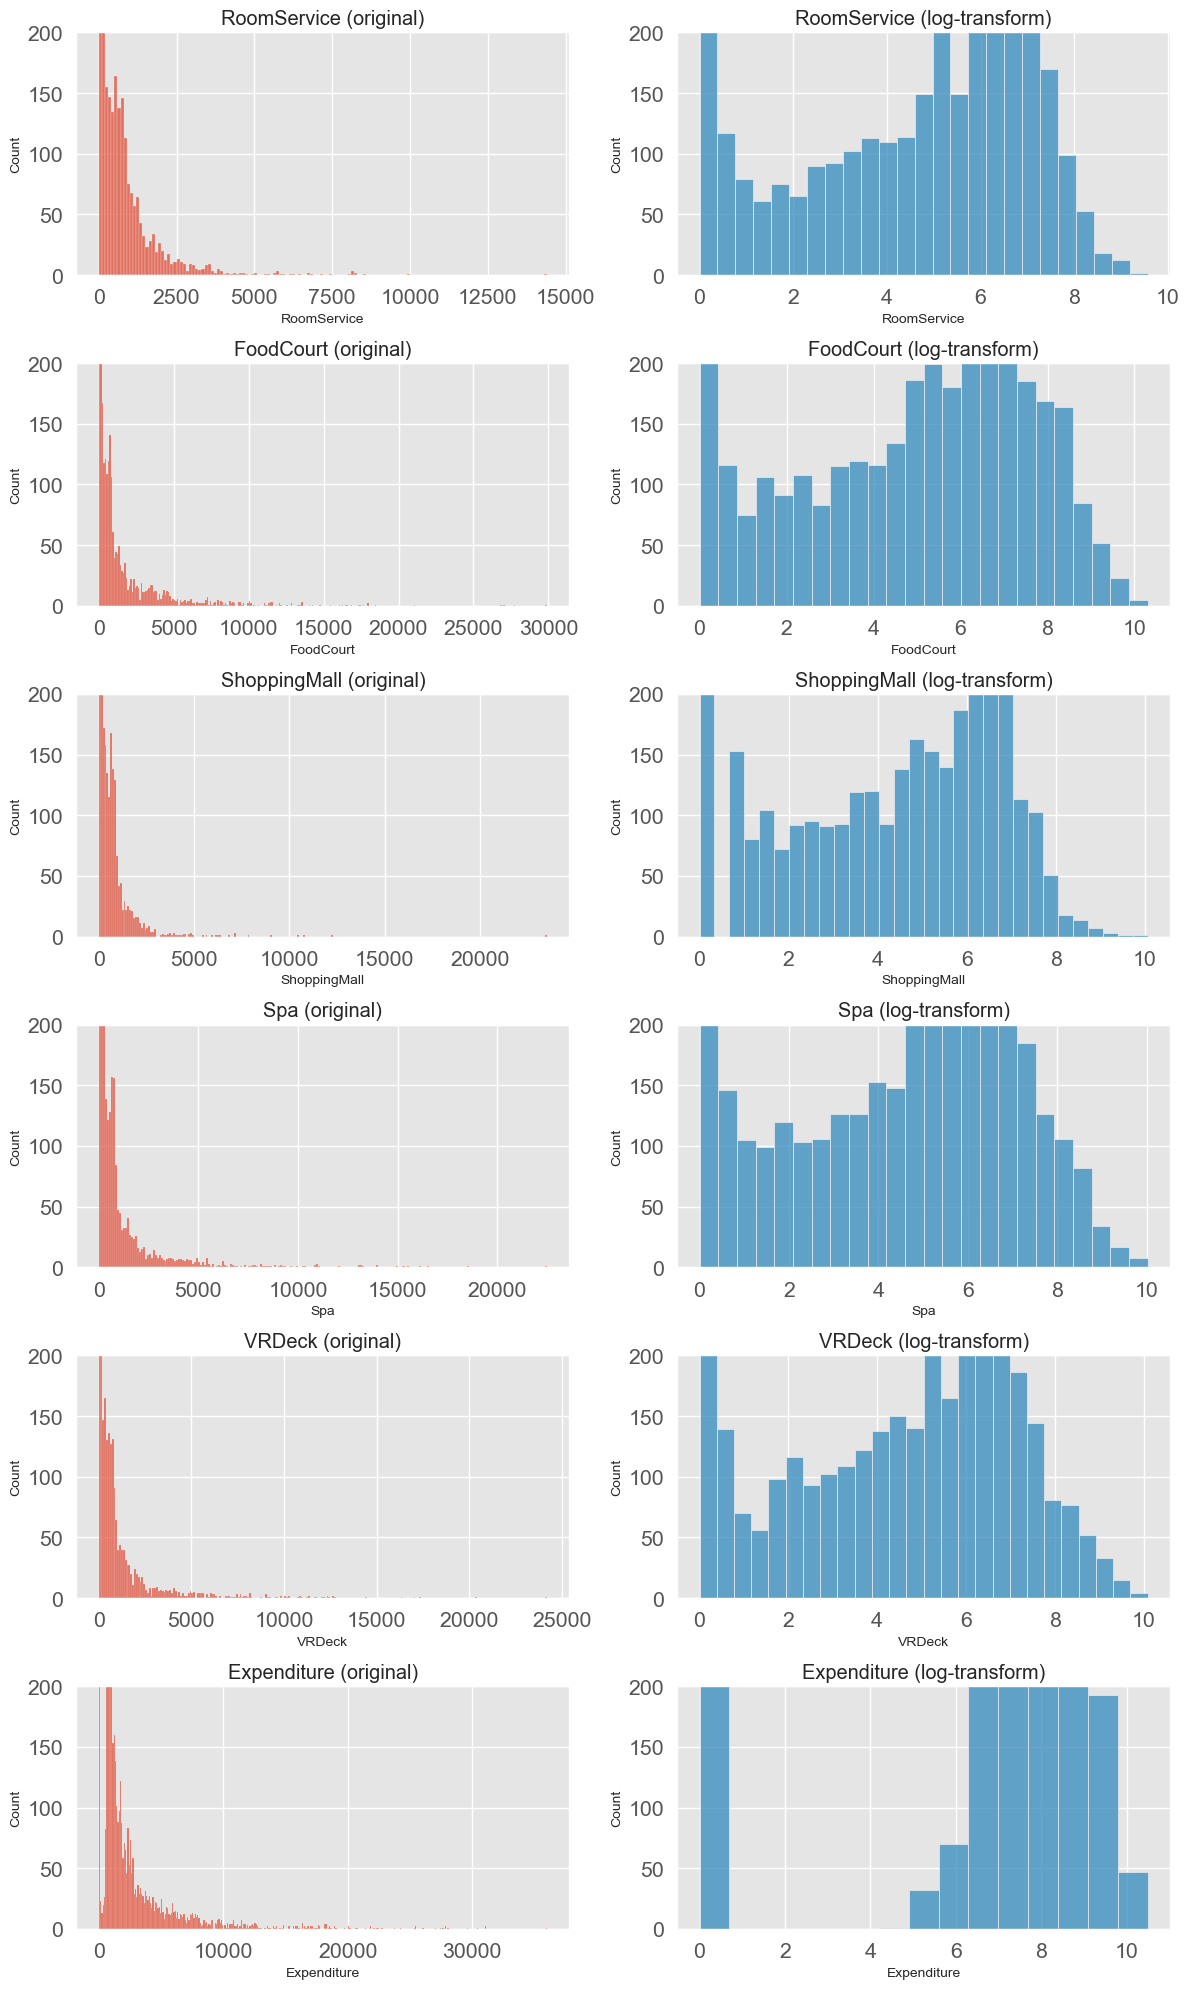

In [72]:
# Plot log transform results
fig = plt.figure(figsize=(12,20))
for i, col in enumerate(['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Expenditure']):
    plt.subplot(6,2,2*i+1)
    sns.histplot(X[col],binwidth=100)
    plt.ylim([0,200])
    plt.title(f'{col} (original)')
    
    plt.subplot(6,2,2*i+2)
    sns.histplot(np.log(1+X[col]),color='C1')
    plt.ylim([0,200])
    plt.title(f'{col} (log-transform)')

fig.tight_layout()
plt.show()

In [73]:
# Apply log transform
for col in [expenditure, 'Expenditure']:
    X[col]=np.log(1+X[col])
    X_test[col]=np.log(1+X_test[col])
                  

**Encoding**

We will use colmn tranformers to be more professional. It's also good practice.

In [74]:
# Identify numerical and categorical columns
numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64','float64']]
categorical_cols = [cname for cname in X.columns if X[cname].dtype == 'object']

#Scale numerical data to have mean=0 and variance=1
numerical_transformer = Pipeline(steps=[('scaler',StandardScaler())])

# One-hot encode categorical data
categorical_transformer = Pipeline(steps=[('onehot',OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse=False))])

#Combine preprocessing
ct = ColumnTransformer(
    transformers=[
        ('num',numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)],
    remainder='passthrough')

# Apply preprocessing
X = ct.fit_transform(X)
X_test = ct.transform(X_test)
    

**PCA**

Just for fun, let's look at the transformed data in PCA space. This gives a low diagonal representation of the data, which preserves local and global structure.

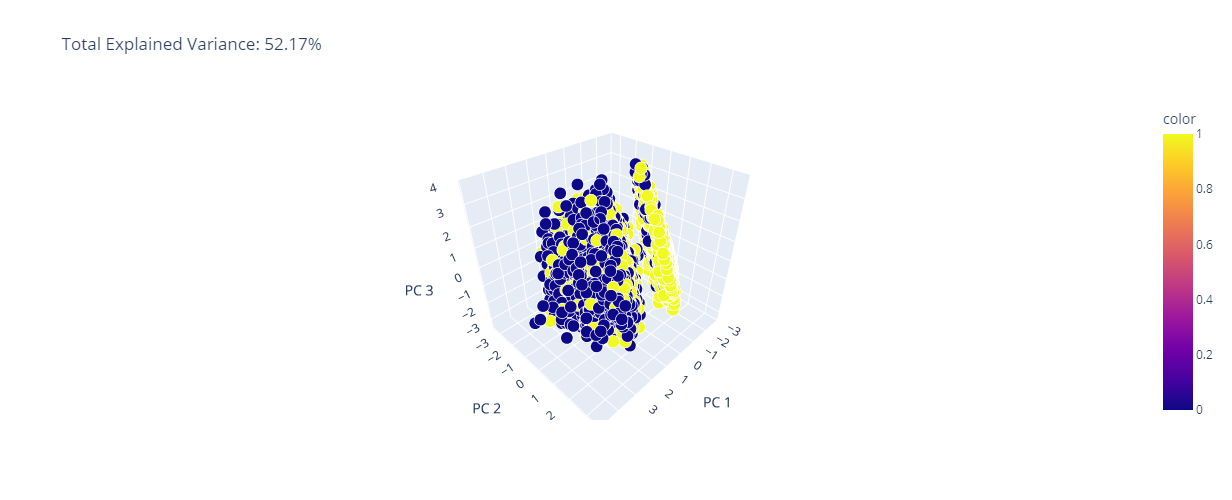

In [75]:
pca = PCA(n_components = 3)
components = pca.fit_transform(X)

total_var = pca.explained_variance_ratio_.sum()*100

fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=y, size=0.1*np.ones(len(X)), opacity = 1,
    title = f'Total Explained Variance: {total_var:.2f}%',
    labels = {'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'},
    width = 800, height = 500)
fig.show()

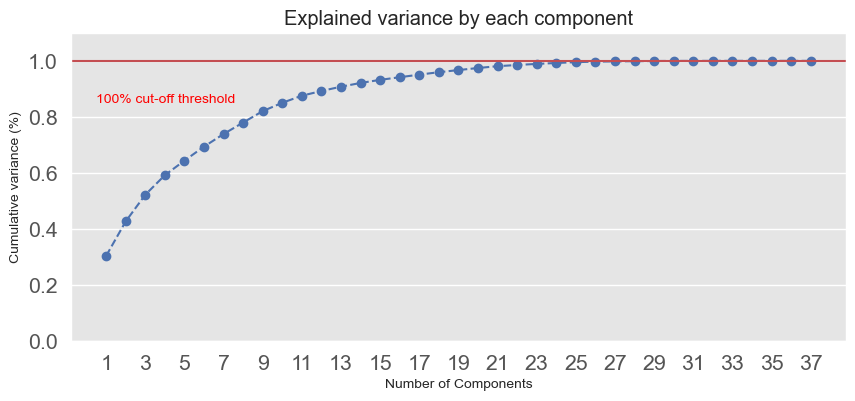

In [76]:
# Explained variance (how important each additional principal component is)
pca = PCA().fit(X)
fig, ax = plt.subplots(figsize=(10,4))
xi = np.arange(1, 1+X.shape[1],step=1)
yi = np.cumsum(pca.explained_variance_ratio_)
plt.plot(xi, yi, marker='o', linestyle='--', color='b')

# Aesthetics
plt.ylim(0.0, 1.1)
plt.xlabel('Number of Components')
plt.xticks(np.arange(1, 1+X.shape[1], step=2))
plt.ylabel('Cumulative variance (%)')
plt.title('Explained variance by each component')
plt.axhline(y=1, color='r', linestyle='-')
plt.text(0.5, 0.85, '100% cut-off threshold', color = 'red')
ax.grid(axis = 'x')

**Create a validation set**

We will use this to choose which model(s) to use.

In [77]:
# Train-validation split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, train_size=0.8, test_size=0.2, random_state=0)

## Model Selection

To briefly mention the algorithms we will use,

**Logistic Regression**: Unlike linear regression which uses Least Squares, this model uses Maximum Likelihood Estimation to fit a sigmoid-curve on the target variable distribution. The sigmoid/logistic curve is commonly use when the data is questions had binary output.

**K-Nearest Neighbors**: KNN works by selecting the majority class of the k-nearest neighbours, where the metric used is usually Euclidean distance. It is a simple and effective algorithm but can be senstive by many factors e.g. the value of k, the preprocessing done to the data and the metric used.

**Support Vector Machine(SVM)**: SVM find the optimal hyperplane that separates the data in the feature space. Predictions are made by looking at which side of the hyperplane the test point lies on. Ordinary SVM assumes the data is linearly separable, which is not always the case. A kernel trick can be use when this assumption fails to transform the data into a higher dimensional space where it is linearly separable SVM is a popular algorithm because it is computationally efficient and produce very high results.

**RandomForest (RF)**: RF is a reliable ensemble of decision trees, which can be used for regression or classificaton problems. Here, the individual trees are built via bagging (i.e. aggregation of bootstraps which are nothing but multiple train datasets created via sampling with replacement) and spli using fewer features. The resulting diverse forest of uncorrelated trees exhibits reduced variance; therefore, is more robust towards change in data and carries is prediction accuracy to new data. It works well with both continuous & categorical data.

**XGBoostExtreme Gradient Boosting (XGBoost)**: XGBoost is similar to RF in that it is made up of an ensemble of decision-trees. The difference arises in how those trees as derived; XGboost uses extreme gradient boosting when optimising its objective function. It often produces the best results but is relatively slow compared to other gradient boosting algorithms.

**Light Gradient Boosting Machine (LGBM)**: LGBM works essentially the same as XGBoost but with a lighter boosting technique. It usually produces similar results to XGBoost but is significantly faster.

**Categorical Boosting (CatBoost)**: CatBoost is an open source algorithm based on gradient boosted decision trees. It supports numerical, categorical and text features. It works well with heterogeneous data and even relatively small data. Informally, it tries to take the best of both worlds from XGBoost and LGBM.

**Naive Bayes (NB)**: Naive Bayes learns how to classify samples by using Bayes' Theorem. It uses prior information to 'update' the probability of an event by incoorporateing this information according to Bayes' law. The algorithm is quite fast but a downside is that it assumes the input features are independent, which is not always the case.

We will train these models and evaluate them on the validation set to then choose which ones carry through to the next stage(cross validation).

**Define classifiers**

In [94]:
# Classifiers
classifiers = {
    "LogisticRegression" : LogisticRegression(random_state=0),
    "KNN" : KNeighborsClassifier(),
    "SVC" : SVC(random_state=0, probability=True),
    "RandomForest" : RandomForestClassifier(random_state=0),
    #"XGBoost" : XGBClassifier(random_state=0, use_label_encoder=False, eval_metric='logloss'), # XGBoost takes too long
    "LGBM" : LGBMClassifier(random_state=0),
    "CatBoost" : CatBoostClassifier(random_state=0, verbose=False),
    "NaiveBayes": GaussianNB()
}

# Grids for grid search
LR_grid = {'penalty' : ['l1','l2'],
           'C': [0.25, 0.5, 0.75, 1, 1.25, 1.5],
           'max_iter': [50, 100, 150]}

KNN_grid = {'n_neighbors': [3, 5, 7, 9],
            'p': [1, 2]}

SVC_grid = {'C': [0.25, 0.5, 0.75, 1, 1.25, 1.5],
            'kernel': ['linear', 'rbf'],
            'gamma':['scale', 'auto']}

RF_grid = {'n_estimators': [50, 100, 150, 200, 250, 300],
        'max_depth': [4, 6, 8, 10, 12]}

boosted_grid = {'n_estimators': [50, 100, 150, 200],
        'max_depth': [4, 8, 12],
        'learning_rate': [0.05, 0.1, 0.15]}

NB_grid={'var_smoothing': [1e-10, 1e-9, 1e-8, 1e-7]}

# Dictionary of all grids
grid = {
    "LogisticRegression" : LR_grid,
    "KNN" : KNN_grid,
    "SVC" : SVC_grid,
    "RandomForest" : RF_grid,
    "XGBoost" : boosted_grid,
    "LGBM" : boosted_grid,
    "CatBoost" : boosted_grid,
    "NaiveBayes": NB_grid
}

In [95]:
classifiers.items()

dict_items([('LogisticRegression', LogisticRegression(random_state=0)), ('KNN', KNeighborsClassifier()), ('SVC', SVC(probability=True, random_state=0)), ('RandomForest', RandomForestClassifier(random_state=0)), ('LGBM', LGBMClassifier(random_state=0)), ('CatBoost', <catboost.core.CatBoostClassifier object at 0x000001FB56FBA500>), ('NaiveBayes', GaussianNB())])

**Train and evaluate models**

Train mdels with grid search (but no cross validation so it doesn't take too long to get a rough idea of which are the best modelos for this dataset.

In [96]:
i = 0
clf_best_params = classifiers.copy()
valid_scores = pd.DataFrame({'Classifier' : classifiers.keys(), 'Validation accuracy': np.zeros(len(classifiers)), 'Training time': np.zeros(len(classifiers))})
for key, classifier in classifiers.items():
    start = time.time()
    clf = GridSearchCV(estimator=classifier, param_grid=grid[key], n_jobs=-1, cv=None)
    
    # Train and score
    clf.fit(X_train, y_train)
    valid_scores.iloc[i, 1] = clf.score(X_valid, y_valid)
    
    # Save trained model
    
    clf_best_params[key] = clf.best_params_
    
    # Print iteration and training time
    stop = time.time()
    valid_scores.iloc[i,2] = np.round((stop - start)/60, 2)
    
    print('Model:', key)
    print('Training time (mins):', valid_scores.iloc[i,2])
    print('')
    i+=1
                             

Model: LogisticRegression
Training time (mins): 0.08

Model: KNN
Training time (mins): 0.02

Model: SVC
Training time (mins): 2.28

Model: RandomForest
Training time (mins): 0.29

Model: LGBM
Training time (mins): 0.09

Model: CatBoost
Training time (mins): 3.85

Model: NaiveBayes
Training time (mins): 0.0



In [97]:
# Show results
valid_scores

Classifier  Validation accuracy  Training time
0  LogisticRegression             0.769408           0.08
1                 KNN             0.756757           0.02
2                 SVC             0.790684           2.28
3        RandomForest             0.787809           0.29
4                LGBM             0.797585           0.09
5            CatBoost             0.806786           3.85
6          NaiveBayes             0.739505           0.00

Motivated by this we will take LGBM and CatBoost to the final stage of modelling.

In [98]:
# Show best parameters from grid search
clf_best_params

{'LogisticRegression': {'C': 0.75, 'max_iter': 50, 'penalty': 'l2'},
 'KNN': {'n_neighbors': 7, 'p': 1},
 'SVC': {'C': 1.5, 'gamma': 'scale', 'kernel': 'rbf'},
 'RandomForest': {'max_depth': 12, 'n_estimators': 300},
 'LGBM': {'learning_rate': 0.1, 'max_depth': 12, 'n_estimators': 50},
 'CatBoost': {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200},
 'NaiveBayes': {'var_smoothing': 1e-07}}

## Modelling

We can finally train our best model on the whole training set using cross validation and ensembling predictions together to produce the most confident predictions.

**Defie best models**

In [99]:
# Classifiers
best_classifiers = {
    'LGBM': LGBMClassifier(**clf_best_params['LGBM'], random_state=0),
    'CatBoost': CatBoostClassifier(**clf_best_params['CatBoost'], verbose=False, random_state=0),
}

**Cross validation and ensembling predictions**

In [102]:
# Number of folds in cross validation
FOLDS=10

preds=np.zeros(len(X_test))
for key, classifier in best_classifiers.items():
    start = time.time()
    
    # 10-fold cross validation
    cv = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=0)
    
    score=0
    for fold, (train_idx,val_idx) in enumerate(cv.split(X, y)):
        # Get traning and validation sets
        X_train, X_valid = X[train_idx], X[val_idx]
        y_train, y_valid = y[train_idx], y[val_idx]
        
        # Train model
        clf = classifier
        clf.fit(X_train, y_train)
        
        # Make predictions and measure accuracy
        preds += clf.predict_proba(X_test)[:,1]
        score += clf.score(X_valid, y_valid)
    
    # Average accuracy
    score=score/FOLDS
    
    # Stop timer
    stop = time.time()
    
    # Print accuracy and time
    print('Model:', key)
    print('Average validation accuracy:', np.round(100*score,2))
    print('Training time(mins):', np.round((stop - start)/60,2))
    print('')
    
# Ensemble predictions
preds=preds/(FOLDS*len(best_classifiers))               

Model: LGBM
Average validation accuracy: 81.03
Training time(mins): 0.01

Model: CatBoost
Average validation accuracy: 81.27
Training time(mins): 0.11



## Submission

Let's look at the distribuion of the predicted probabilities.

Text(0.5, 0, 'Probability')

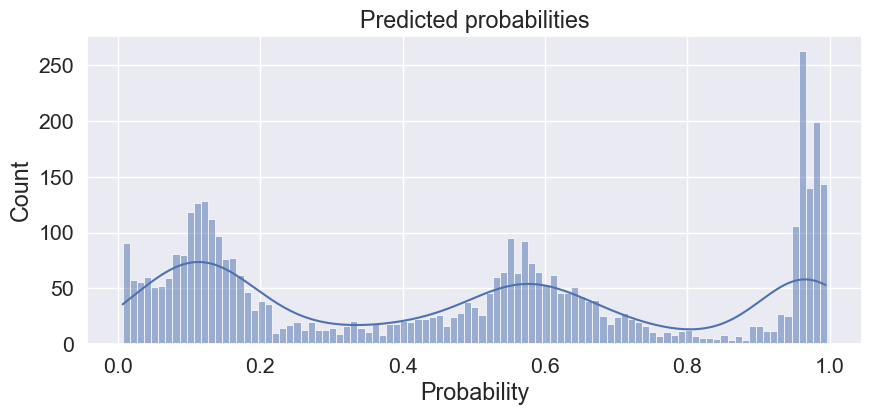

In [103]:
plt.figure(figsize=(10,4))
sns.histplot(preds, binwidth=0.01, kde=True)
plt.title('Predicted probabilities')
plt.xlabel('Probability')

It s iteresting to see that the models are either very confident or very unconfident but not much in between.

**Post processing**

Finally, we need to convert each predicted probability into one of the two classes(transport or not). The simplest way is to round each probability to the nearest integer (0 for False or 1 for True). However assuming the train and test sets have similar distributions, we can tune the classification threshold to obtain a similar proportion of transported/not transported in our predictions as in train set. Remember that the proportion of transpored passengers in the train set was 50,4%.

In [104]:
# Proportion (in test set) we get from rouding
print(np.round(100*np.round(preds).sum()/len(preds),2))

51.74


Our models seem to (potentially) overestimate the number of transported passengers in the test set. Let's ry to bring that proportion down a bit.

Optimal threshold: 0.518


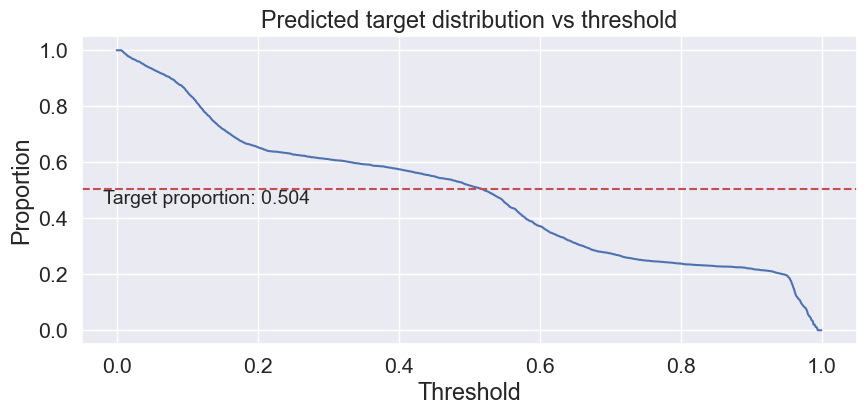

In [114]:
# Proportion of predicted positive (transported) classes
def preds_prop(preds_arr, thresh):
    pred_classes=(preds_arr>=thresh).astype(int)
    return pred_classes.sum()/len(pred_classes)

# Plot proportions across a range of thresholds
def plot_preds_prop(preds_arr):
    # Array of thresholds
    T_array=np.arange(0,1,0.001)
    
    # Calculate proportions
    prop=np.zeros(len(T_array))
    for i, T in enumerate(T_array):
        prop[i]=preds_prop(preds_arr, T)
        
    # Plot proportions
    plt.figure(figsize=(10,4))
    plt.plot(T_array, prop)
    target_prop=0.504         # Experiment with this value
    plt.axhline(y=target_prop, color='r', linestyle='--')
    plt.text(-0.02,0.45,f'Target proportion: {target_prop}', fontsize=14)
    plt.title('Predicted target distribution vs threshold')
    plt.xlabel('Threshold')
    plt.ylabel('Proportion')
    
    # Find optimal threshold (the one that leads to the proportion being closest to target_prop)
    T_opt=T_array[np.abs(prop-target_prop).argmin()]
    print('Optimal threshold:', T_opt)
    return T_opt
    
T_opt=plot_preds_prop(preds)

In [115]:
# Classify test set using optimal threshold
preds_tuned=(preds>=T_opt).astype(int)

**Submit predictions**

Text(0.5, 1.0, 'Prediction distribution')

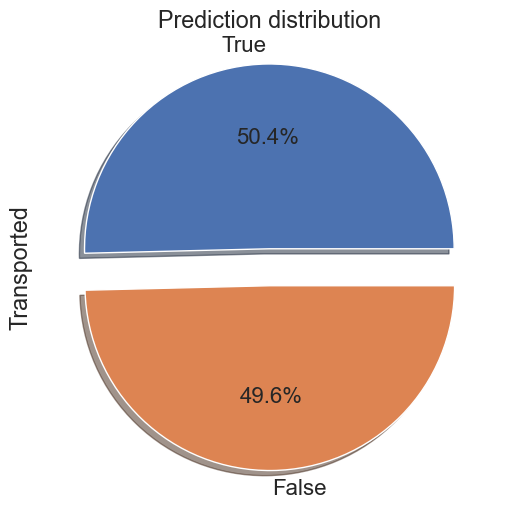

In [116]:
# Sample submission (to get right format)
sub=pd.read_csv(r'C:\Users\Raul\Desktop\Kaggle\Space/sample_submission.csv')

# Add predictions
sub['Transported']=preds_tuned

# Replace 0 to False and 1 to True
sub=sub.replace({0:False, 1:True})

# Prediction distribution
plt.figure(figsize=(6,6))
sub['Transported'].value_counts().plot.pie(explode=[0.1,0.1], autopct='%1.1f%%', shadow=True, textprops={'fontsize':16}).set_title("Prediction distribution")

In [117]:
# Output to csv
sub.to_csv('submission.csv', index=False)